# Load Data

In [ ]:
#untuk olah data
!pip install pycountry

import pandas as pd
import numpy as np
import datetime as dt
import pycountry
import re
import sklearn
from sklearn.metrics import confusion_matrix

#untuk plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import folium
from folium import Marker
from folium.plugins import MarkerCluster

#untuk membuat model time-series
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error

     |████████████████████████████████| 10.1 MB 8.5 MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746883 sha256=5662f2a8699597b88df8e7382179a2c0d8961dc56a814f1e6528a66025492bcc
  Stored in directory: /root/.cache/pip/wheels/57/e8/3f/120ccc1ff7541c108bc5d656e2a14c39da0d824653b62284c6
Successfully built pycountry


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Supraventricular tachycardia/Daily Update Data Agregat Covid-19 Jakarta.xlsx')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Tanggal          547 non-null    datetime64[ns]
 1   Jam              528 non-null    float64       
 2   Tanggal Jam      547 non-null    datetime64[ns]
 3   Meninggal        547 non-null    int64         
 4   Sembuh           547 non-null    int64         
 5   Self Isolation   547 non-null    int64         
 6   Masih Perawatan  547 non-null    int64         
 7   Total Pasien     547 non-null    int64         
 8   Positif Harian   547 non-null    int64         
 9   Positif Aktif    547 non-null    int64         
 10  Sembuh Harian    547 non-null    int64         
 11  Tanpa Gejala     407 non-null    float64       
 12  Bergejala        407 non-null    float64       
 13  Belum Ada Data   407 non-null    float64       
dtypes: datetime64[ns](2), float64(4), int64(8)

,Tanggal,Jam,Tanggal Jam,Meninggal,Sembuh,Self Isolation,Masih Perawatan,Total Pasien,Positif Harian,Positif Aktif,Sembuh Harian,Tanpa Gejala,Bergejala,Belum Ada Data
0,2020-03-01,NaN,2020-03-01 18:00:00,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,2020-03-02,NaN,2020-03-02 18:00:00,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,2020-03-03,NaN,2020-03-03 18:00:00,1,0,0,2,3,3,2,0,NaN,NaN,NaN
3,2020-03-04,NaN,2020-03-04 18:00:00,1,0,0,2,3,0,2,0,NaN,NaN,NaN
4,2020-03-05,NaN,2020-03-05 18:00:00,3,0,0,4,7,4,4,0,NaN,NaN,NaN


# EDA

## Data Jakarta

In [ ]:
data_jakarta = pd.read_excel('/content/drive/MyDrive/Supraventricular tachycardia/Daily Update Data Agregat Covid-19 Jakarta.xlsx', 'Data Jakarta')
data_jakarta

,Tanggal,Jam,Tanggal Jam,Meninggal,Sembuh,Self Isolation,Masih Perawatan,Total Pasien,Positif Harian,Positif Aktif,Sembuh Harian,Tanpa Gejala,Bergejala,Belum Ada Data
0,2020-03-01,NaN,2020-03-01 18:00:00.000,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,2020-03-02,NaN,2020-03-02 18:00:00.000,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,2020-03-03,NaN,2020-03-03 18:00:00.000,1,0,0,2,3,3,2,0,NaN,NaN,NaN
3,2020-03-04,NaN,2020-03-04 18:00:00.000,1,0,0,2,3,0,2,0,NaN,NaN,NaN
4,2020-03-05,NaN,2020-03-05 18:00:00.000,3,0,0,4,7,4,4,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,2021-08-25,8.0,2021-08-25 07:59:59.712,13214,826302,5442,2731,847689,789,8173,729,0.0,0.0,8173.0
543,2021-08-26,8.0,2021-08-26 07:59:59.712,13216,827333,5110,2604,848263,574,7714,1031,0.0,0.0,7714.0
544,2021-08-27,8.0,2021-08-27 07:59:59.712,13232,827674,5491,2504,848901,638,7995,341,0.0,0.0,7995.0
545,2021-08-28,8.0,2021-08-28 07:59:59.712,13242,828125,5607,2395,849369,468,8002,451,0.0,0.0,8002.0


In [ ]:
data_jakarta = data_jakarta[['Tanggal', 'Self Isolation', 'Masih Perawatan', 'Total Pasien', 'Sembuh Harian', 'Positif Harian']]
data_jakarta

,Tanggal,Self Isolation,Masih Perawatan,Total Pasien,Sembuh Harian,Positif Harian
0,2020-03-01,0,0,0,0,0
1,2020-03-02,0,0,0,0,0
2,2020-03-03,0,2,3,0,3
3,2020-03-04,0,2,3,0,0
4,2020-03-05,0,4,7,0,4
...,...,...,...,...,...,...
542,2021-08-25,5442,2731,847689,729,789
543,2021-08-26,5110,2604,848263,1031,574
544,2021-08-27,5491,2504,848901,341,638
545,2021-08-28,5607,2395,849369,451,468


In [ ]:
mean_positif_jakarta = data_jakarta[["Positif Harian"]].mean(skipna=True)
mean_positif_jakarta

Positif Harian    1553.64351
dtype: float64

In [ ]:
median_positif_jakarta = data_jakarta[["Positif Harian"]].median(skipna=True)
median_positif_jakarta

Positif Harian    926.0
dtype: float64

In [ ]:
data_jakarta[["Positif Harian"]].describe()

,Positif Harian
count,547.000000
mean,1553.643510
std,2306.430548
min,0.000000
25%,287.500000
50%,926.000000
75%,1587.500000
max,14619.000000


In [ ]:
min_positif_jakarta = data_jakarta[["Positif Harian"]].min()
min_positif_jakarta

Positif Harian    0
dtype: int64

In [ ]:
max_positif_jakarta = data_jakarta[["Positif Harian"]].max()
max_positif_jakarta

Positif Harian    14619
dtype: int64

In [ ]:
def data_outlier(column):
  sorted(column)
  Q1, Q3 = np.percentile(column, [25, 75])
  IQR = Q3 - Q1
  lower_range = Q1 - (1.5 * IQR)
  upper_range = Q3 + (1.5 * IQR)
  return lower_range, upper_range

In [ ]:
lower_bound, upper_bound = data_outlier(data_jakarta['Positif Harian'])
print("lower bound =", lower_bound, ", upper bound =", upper_bound)

lower bound = -1662.5 , upper bound = 3537.5


In [ ]:
outlier_positif_jakarta = data_jakarta['Positif Harian'].loc[(data_jakarta['Positif Harian'] < lower_bound) | (data_jakarta['Positif Harian'] > upper_bound)]
pd.DataFrame(outlier_positif_jakarta)

,Positif Harian
325,3786
327,3792
337,3614
339,3567
340,3632
343,4213
348,3810
473,4144
474,4737
475,4895


In [ ]:
print("Jumlah data outlier adalah", outlier_positif_jakarta.shape[0], "baris")

Jumlah data outlier adalah 48 baris


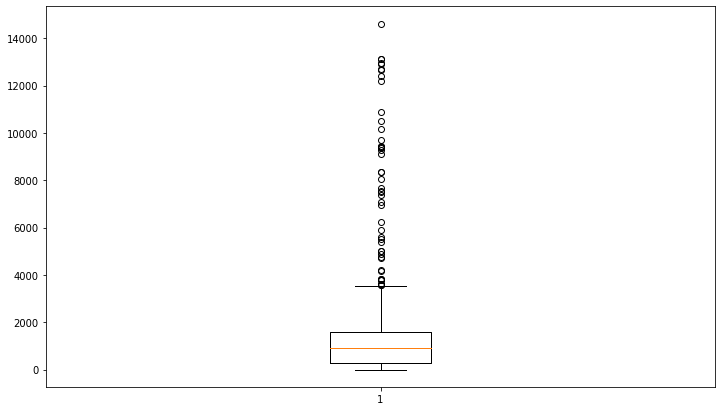

In [ ]:
plt.figure(figsize=(12, 7))
plt.boxplot(data_jakarta['Positif Harian'])
plt.show()

In [ ]:
# Membuat Total Pasien Menjadi Harian
data_jakarta['Total Pasien shifted'] = data_jakarta['Total Pasien'].shift(1)
data_jakarta.fillna(0, inplace= True)
data_jakarta['Jumlah Pasien Harian'] = data_jakarta['Total Pasien']-data_jakarta['Total Pasien shifted']
data_jakarta = data_jakarta.drop(['Total Pasien', 'Total Pasien shifted'], axis=1)
data_jakarta

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4327: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

,Tanggal,Self Isolation,Masih Perawatan,Sembuh Harian,Positif Harian,Jumlah Pasien Harian
0,2020-03-01,0,0,0,0,0.0
1,2020-03-02,0,0,0,0,0.0
2,2020-03-03,0,2,0,3,3.0
3,2020-03-04,0,2,0,0,0.0
4,2020-03-05,0,4,0,4,4.0
...,...,...,...,...,...,...
542,2021-08-25,5442,2731,729,789,789.0
543,2021-08-26,5110,2604,1031,574,574.0
544,2021-08-27,5491,2504,341,638,638.0
545,2021-08-28,5607,2395,451,468,468.0


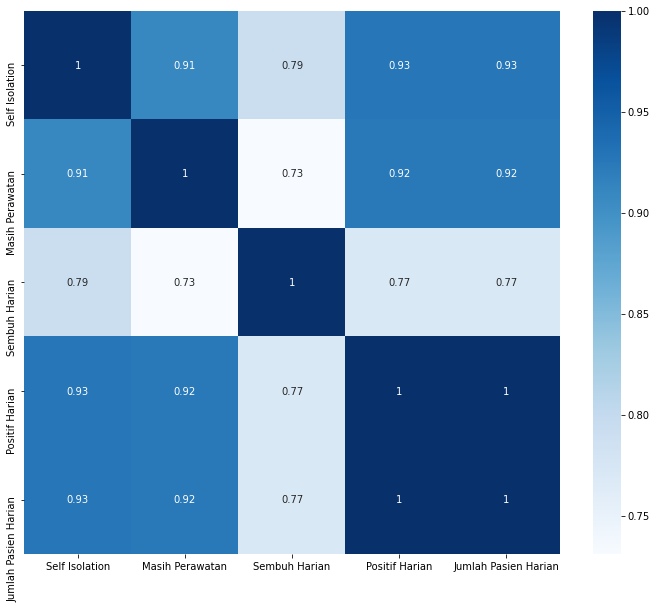

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(data_jakarta.corr(),cmap='Blues',annot=True) 

In [ ]:
self_iso_jkt = data_jakarta["Self Isolation"]
pos_jkt = data_jakarta["Positif Harian"]
korelasi = self_iso_jkt.corr(pos_jkt)
korelasi

0.9259228105351918

In [ ]:
data_jakarta.shape

(547, 6)

In [ ]:
data_jakarta.describe()

,Self Isolation,Masih Perawatan,Sembuh Harian,Positif Harian,Jumlah Pasien Harian
count,547.000000,547.000000,547.000000,547.000000,547.000000
mean,9511.301645,4258.358318,1515.243144,1553.643510,1553.643510
std,14636.809299,4939.765577,2631.014159,2306.430548,2306.430548
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3220.000000,1953.500000,195.500000,287.500000,287.500000
50%,5402.000000,2947.000000,920.000000,926.000000,926.000000
75%,9395.000000,4465.000000,1436.000000,1587.500000,1587.500000
max,88295.000000,30418.000000,20570.000000,14619.000000,14619.000000


In [ ]:
data_jakarta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Tanggal               547 non-null    datetime64[ns]
 1   Self Isolation        547 non-null    int64         
 2   Masih Perawatan       547 non-null    int64         
 3   Sembuh Harian         547 non-null    int64         
 4   Positif Harian        547 non-null    int64         
 5   Jumlah Pasien Harian  547 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 25.8 KB


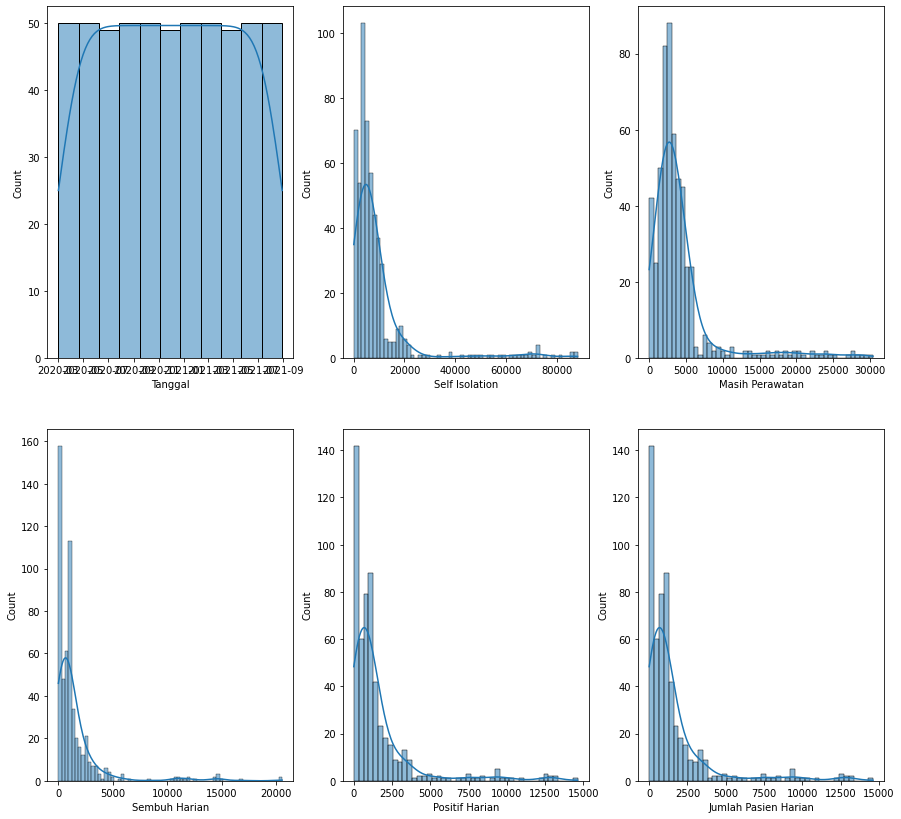

In [ ]:
# Melakukan visualisasi distribusi data Jakarta
k = data_jakarta.columns.values
number_of_columns=3
number_of_rows = len(k)-1/number_of_columns
plt.figure(figsize=(5*number_of_columns,8*number_of_rows))
for i in range(0,len(k)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.histplot(data_jakarta[k[i]],kde=True) 

Pearson Correlation untuk variabel Self Isolation dan Positif Harian = 0.9259228105351919
Pearson Correlation untuk variabel Masih Perawatan dan Positif Harian = 0.9244496841101046


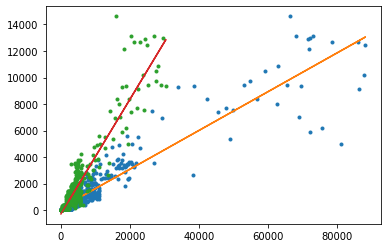

In [ ]:
import scipy.stats as stats
def corr(column1, column2):
  pearson_coef, p_value = stats.pearsonr(data_jakarta[column1], data_jakarta[column2])
  print("Pearson Correlation untuk variabel", column1, "dan", column2, "=", pearson_coef)
  plt.plot(data_jakarta[column1], data_jakarta[column2], '.')
  m, b = np.polyfit(data_jakarta[column1], data_jakarta[column2], 1)
  plt.plot(data_jakarta[column1], m*data_jakarta[column1] + b)

corr('Self Isolation', 'Positif Harian')
corr('Masih Perawatan', 'Positif Harian')

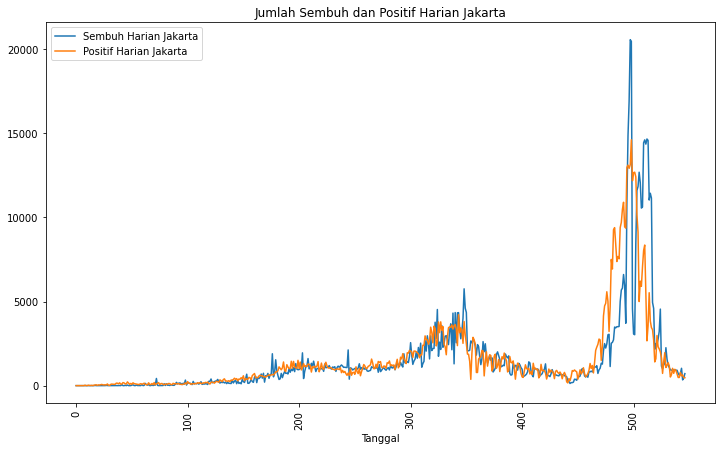

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(data_jakarta.index, data_jakarta['Sembuh Harian'], label ='Sembuh Harian Jakarta')
plt.plot(data_jakarta.index, data_jakarta['Positif Harian'], label ='Positif Harian Jakarta')
plt.title('Jumlah Sembuh dan Positif Harian Jakarta')
plt.xlabel('Tanggal')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
cols = ['Tanggal', 'Positif Harian', 'Sembuh Harian']
pos_sembuh_jkt = pd.read_excel('/content/drive/MyDrive/Supraventricular tachycardia/Daily Update Data Agregat Covid-19 Jakarta.xlsx', sheet_name='Data Jakarta', usecols=cols)
pos_sembuh_jkt = pos_sembuh_jkt.set_index(['Tanggal'])
pos_sembuh_jkt

,Positif Harian,Sembuh Harian
Tanggal,,
2020-03-01,0,0
2020-03-02,0,0
2020-03-03,3,0
2020-03-04,0,0
2020-03-05,4,0
...,...,...
2021-08-25,789,729
2021-08-26,574,1031
2021-08-27,638,341


In [ ]:
data_mar = pos_sembuh_jkt.loc['2020-03-01':'2020-03-31']
data_apr = pos_sembuh_jkt.loc['2020-04-01':'2020-04-30']
data_mei2020 = pos_sembuh_jkt.loc['2020-05-01':'2020-05-31']
data_jun = pos_sembuh_jkt.loc['2020-06-01':'2020-06-30']
data_jul = pos_sembuh_jkt.loc['2020-07-01':'2020-07-31']
data_agst = pos_sembuh_jkt.loc['2020-08-01':'2020-08-31']
data_sept = pos_sembuh_jkt.loc['2020-09-01':'2020-09-30']
data_okt = pos_sembuh_jkt.loc['2020-10-01':'2020-10-31']
data_nov = pos_sembuh_jkt.loc['2020-11-01':'2020-11-30']
data_dec = pos_sembuh_jkt.loc['2020-12-01':'2020-12-31']
data_jan = pos_sembuh_jkt.loc['2021-01-01':'2021-01-31']
data_feb = pos_sembuh_jkt.loc['2021-02-01':'2021-02-28']
data_maret = pos_sembuh_jkt.loc['2021-03-01':'2021-03-31']
data_april = pos_sembuh_jkt.loc['2021-04-01':'2021-04-30']
data_mei = pos_sembuh_jkt.loc['2021-05-01':'2021-05-31']
data_juni = pos_sembuh_jkt.loc['2021-06-01':'2021-06-30']
data_juli = pos_sembuh_jkt.loc['2021-07-01':'2021-07-31']
data_agus = pos_sembuh_jkt.loc['2021-08-01':'2021-08-31']

In [ ]:
mar_mean = data_mar.mean()
apr_mean = data_apr.mean()
mei2020_mean = data_mei2020.mean()
jun_mean = data_jun.mean()
jul_mean = data_jul.mean()
agst_mean = data_agst.mean()
sept_mean = data_sept.mean()
okt_mean = data_okt.mean()
nov_mean = data_nov.mean()
dec_mean = data_dec.mean()
jan_mean = data_jan.mean()
feb_mean = data_feb.mean()
maret_mean = data_maret.mean()
april_mean = data_april.mean()
mei_mean = data_mei.mean()
juni_mean = data_juni.mean()
juli_mean = data_juli.mean()
agus_mean = data_agus.mean()

data_bulan = ([mar_mean, apr_mean, mei2020_mean, jun_mean, jul_mean, agst_mean, sept_mean, okt_mean, nov_mean, dec_mean, jan_mean, feb_mean, maret_mean, april_mean, mei_mean, juni_mean, juli_mean, agus_mean])
data_bulan_mean = pd.DataFrame(data=data_bulan)

In [ ]:
data_bulan_mean['Positif Harian Shifted'] = data_bulan_mean['Positif Harian'].shift(1)
data_bulan_mean['Sembuh Harian Shifted'] = data_bulan_mean['Sembuh Harian'].shift(1)
data_bulan_mean

,Positif Harian,Sembuh Harian,Positif Harian Shifted,Sembuh Harian Shifted
0,23.903226,1.580645,NaN,NaN
1,113.233333,12.100000,23.903226,1.580645
2,101.096774,54.516129,113.233333,12.100000
3,133.466667,147.000000,101.096774,54.516129
4,320.161290,216.000000,133.466667,147.000000
5,616.387097,559.032258,320.161290,216.000000
6,1135.300000,992.733333,616.387097,559.032258
7,1007.387097,1100.451613,1135.300000,992.733333
8,1042.133333,988.133333,1007.387097,1100.451613
9,1512.064516,1316.225806,1042.133333,988.133333


In [ ]:
data_bulan_mean['Angka Kenaikan Positif Jakarta (%)'] = ((data_bulan_mean['Positif Harian']-data_bulan_mean['Positif Harian Shifted'])/data_bulan_mean['Positif Harian Shifted'])*100
data_bulan_mean['Angka Kenaikan Sembuh Jakarta (%)'] = ((data_bulan_mean['Sembuh Harian']-data_bulan_mean['Sembuh Harian Shifted'])/data_bulan_mean['Sembuh Harian Shifted'])*100
data_bulan_mean

,Positif Harian,Sembuh Harian,Positif Harian Shifted,Sembuh Harian Shifted,Angka Kenaikan Positif Jakarta (%),Angka Kenaikan Sembuh Jakarta (%)
0,23.903226,1.580645,NaN,NaN,NaN,NaN
1,113.233333,12.100000,23.903226,1.580645,373.715700,665.510204
2,101.096774,54.516129,113.233333,12.100000,-10.718186,350.546521
3,133.466667,147.000000,101.096774,54.516129,32.018719,169.644970
4,320.161290,216.000000,133.466667,147.000000,139.881087,46.938776
5,616.387097,559.032258,320.161290,216.000000,92.523929,158.811231
6,1135.300000,992.733333,616.387097,559.032258,84.186205,77.580689
7,1007.387097,1100.451613,1135.300000,992.733333,-11.266881,10.850676
8,1042.133333,988.133333,1007.387097,1100.451613,3.449144,-10.206562
9,1512.064516,1316.225806,1042.133333,988.133333,45.093192,33.203259


In [ ]:
data_bulan_mean.fillna(0, inplace= True)
data_bulan_mean.replace({np.inf: 0}, inplace=True)
data_bulan_mean['Bulan'] = ['Maret 2020', 'April 2020', 'Mei 2020', 'Juni 2020', 'Juli 2020', 'Agustus 2020', 'September 2020', 'Oktober 2020', 'November 2020', 'Desember 2020', 'Januari 2021', 'Februari 2021', 'Maret 2021', 'April 2021', 'Mei 2021', 'Juni 2021', 'Juli 2021', 'Agustus 2021']
data_bulan_mean

,Positif Harian,Sembuh Harian,Positif Harian Shifted,Sembuh Harian Shifted,Angka Kenaikan Positif Jakarta (%),Angka Kenaikan Sembuh Jakarta (%),Bulan
0,23.903226,1.580645,0.000000,0.000000,0.000000,0.000000,Maret 2020
1,113.233333,12.100000,23.903226,1.580645,373.715700,665.510204,April 2020
2,101.096774,54.516129,113.233333,12.100000,-10.718186,350.546521,Mei 2020
3,133.466667,147.000000,101.096774,54.516129,32.018719,169.644970,Juni 2020
4,320.161290,216.000000,133.466667,147.000000,139.881087,46.938776,Juli 2020
5,616.387097,559.032258,320.161290,216.000000,92.523929,158.811231,Agustus 2020
6,1135.300000,992.733333,616.387097,559.032258,84.186205,77.580689,September 2020
7,1007.387097,1100.451613,1135.300000,992.733333,-11.266881,10.850676,Oktober 2020
8,1042.133333,988.133333,1007.387097,1100.451613,3.449144,-10.206562,November 2020
9,1512.064516,1316.225806,1042.133333,988.133333,45.093192,33.203259,Desember 2020


In [ ]:
cols = ['Bulan', 'Positif Harian', 'Angka Kenaikan Positif Jakarta (%)', 'Sembuh Harian', 'Angka Kenaikan Sembuh Jakarta (%)']
data_persen = data_bulan_mean.set_index(['Bulan'])
data_persen = data_bulan_mean[cols]
data_persen

,Bulan,Positif Harian,Angka Kenaikan Positif Jakarta (%),Sembuh Harian,Angka Kenaikan Sembuh Jakarta (%)
0,Maret 2020,23.903226,0.000000,1.580645,0.000000
1,April 2020,113.233333,373.715700,12.100000,665.510204
2,Mei 2020,101.096774,-10.718186,54.516129,350.546521
3,Juni 2020,133.466667,32.018719,147.000000,169.644970
4,Juli 2020,320.161290,139.881087,216.000000,46.938776
5,Agustus 2020,616.387097,92.523929,559.032258,158.811231
6,September 2020,1135.300000,84.186205,992.733333,77.580689
7,Oktober 2020,1007.387097,-11.266881,1100.451613,10.850676
8,November 2020,1042.133333,3.449144,988.133333,-10.206562
9,Desember 2020,1512.064516,45.093192,1316.225806,33.203259


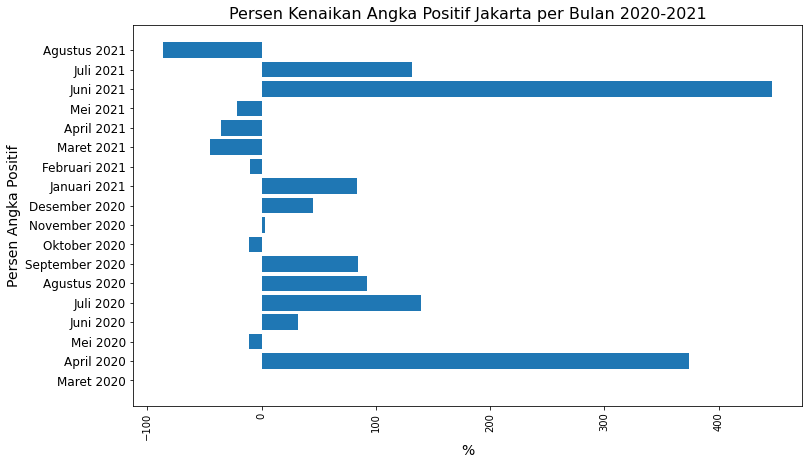

In [ ]:
plt.figure(figsize=(12,7))
plt.barh(data_persen['Bulan'], data_persen['Angka Kenaikan Positif Jakarta (%)'])
plt.title('Persen Kenaikan Angka Positif Jakarta per Bulan 2020-2021', size=16)
plt.xlabel('%', size=14)
plt.ylabel('Persen Angka Positif', size=14)
plt.xticks(rotation=90)
plt.yticks(size=12)
plt.show()

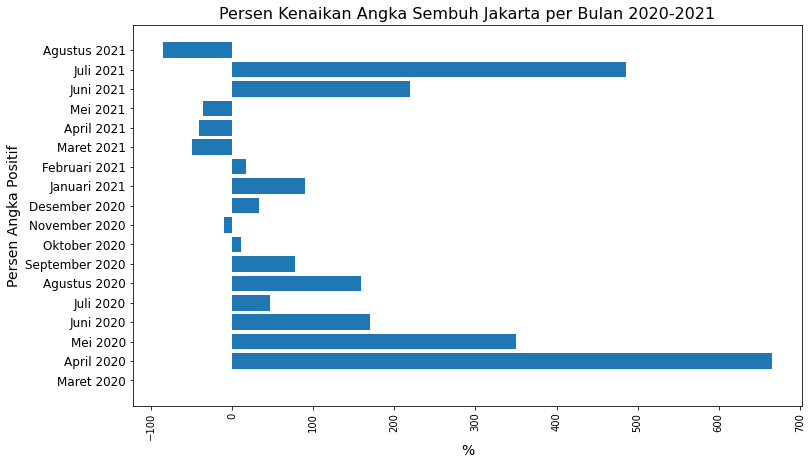

In [ ]:
plt.figure(figsize=(12,7))
plt.barh(data_persen['Bulan'], data_persen['Angka Kenaikan Sembuh Jakarta (%)'])
plt.title('Persen Kenaikan Angka Sembuh Jakarta per Bulan 2020-2021', size=16)
plt.xlabel('%', size=14)
plt.ylabel('Persen Angka Positif', size=14)
plt.xticks(rotation=90)
plt.yticks(size=12)
plt.show()

## Data Google Mobility

In [ ]:
df_2020 = pd.read_csv('/content/drive/MyDrive/Supraventricular tachycardia/2020_ID_Region_Mobility_Report.csv')
df_2021 = pd.read_csv('/content/drive/MyDrive/Supraventricular tachycardia/2021_ID_Region_Mobility_Report.csv')

In [ ]:
df_2020.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,ID,Indonesia,NaN,NaN,NaN,NaN,NaN,ChIJtwRkSdcHTCwRhfStG-dNe-M,2020-02-15,-2.0,-2.0,-8.0,1.0,5,1
1,ID,Indonesia,NaN,NaN,NaN,NaN,NaN,ChIJtwRkSdcHTCwRhfStG-dNe-M,2020-02-16,-3.0,-3.0,-7.0,-4.0,2,2
2,ID,Indonesia,NaN,NaN,NaN,NaN,NaN,ChIJtwRkSdcHTCwRhfStG-dNe-M,2020-02-17,-3.0,-4.0,-7.0,-1.0,3,1
3,ID,Indonesia,NaN,NaN,NaN,NaN,NaN,ChIJtwRkSdcHTCwRhfStG-dNe-M,2020-02-18,-3.0,-2.0,-4.0,1.0,2,1
4,ID,Indonesia,NaN,NaN,NaN,NaN,NaN,ChIJtwRkSdcHTCwRhfStG-dNe-M,2020-02-19,-3.0,-4.0,-3.0,0.0,1,1


In [ ]:
df_2020_jkt = df_2020.loc[df_2020["sub_region_1"] == "Jakarta"]
df_2020_jkt.shape

(321, 15)

In [ ]:
df_2021_jkt = df_2021.loc[df_2021["sub_region_1"] == "Jakarta"]
df_2021_jkt.shape

(237, 15)

In [ ]:
df_concat = pd.concat([df_2020_jkt, df_2021_jkt], axis=0)
df_concat.reset_index(inplace=True)
df_concat.head()

,index,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,4173,ID,Indonesia,Jakarta,NaN,NaN,ID-JK,NaN,ChIJnUvjRenzaS4RILjULejFAAE,2020-02-15,2.0,3.0,16.0,5.0,6,0
1,4174,ID,Indonesia,Jakarta,NaN,NaN,ID-JK,NaN,ChIJnUvjRenzaS4RILjULejFAAE,2020-02-16,-10.0,-10.0,-15.0,-3.0,2,2
2,4175,ID,Indonesia,Jakarta,NaN,NaN,ID-JK,NaN,ChIJnUvjRenzaS4RILjULejFAAE,2020-02-17,-2.0,-1.0,-6.0,2.0,4,1
3,4176,ID,Indonesia,Jakarta,NaN,NaN,ID-JK,NaN,ChIJnUvjRenzaS4RILjULejFAAE,2020-02-18,-1.0,1.0,-3.0,3.0,3,1
4,4177,ID,Indonesia,Jakarta,NaN,NaN,ID-JK,NaN,ChIJnUvjRenzaS4RILjULejFAAE,2020-02-19,-1.0,-3.0,-2.0,3.0,3,1


In [ ]:
df_concat.shape

(558, 16)

In [ ]:
df_concat.dtypes

index                                                   int64
country_region_code                                    object
country_region                                         object
sub_region_1                                           object
sub_region_2                                          float64
metro_area                                            float64
iso_3166_2_code                                        object
census_fips_code                                      float64
place_id                                               object
date                                                   object
retail_and_recreation_percent_change_from_baseline    float64
grocery_and_pharmacy_percent_change_from_baseline     float64
parks_percent_change_from_baseline                    float64
transit_stations_percent_change_from_baseline         float64
workplaces_percent_change_from_baseline                 int64
residential_percent_change_from_baseline                int64
dtype: o

In [ ]:
df_concat.isnull().sum()

index                                                   0
country_region_code                                     0
country_region                                          0
sub_region_1                                            0
sub_region_2                                          558
metro_area                                            558
iso_3166_2_code                                         0
census_fips_code                                      558
place_id                                                0
date                                                    0
retail_and_recreation_percent_change_from_baseline      0
grocery_and_pharmacy_percent_change_from_baseline       0
parks_percent_change_from_baseline                      0
transit_stations_percent_change_from_baseline           0
workplaces_percent_change_from_baseline                 0
residential_percent_change_from_baseline                0
dtype: int64

In [ ]:
df_concat['workplaces_percent_change_from_baseline'] = df_concat['workplaces_percent_change_from_baseline'].astype(float)
df_concat['residential_percent_change_from_baseline'] = df_concat['residential_percent_change_from_baseline'].astype(float)
df_concat['date']= pd.to_datetime(df_concat['date'])

In [ ]:
df_concat.drop(['index', 'country_region_code', 'country_region', 'sub_region_1', 'sub_region_2', 'metro_area', 'iso_3166_2_code', 'census_fips_code', 'place_id'], axis=1, inplace=True)

In [ ]:
df_concat.head()

,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-02-15,2.0,3.0,16.0,5.0,6.0,0.0
1,2020-02-16,-10.0,-10.0,-15.0,-3.0,2.0,2.0
2,2020-02-17,-2.0,-1.0,-6.0,2.0,4.0,1.0
3,2020-02-18,-1.0,1.0,-3.0,3.0,3.0,1.0
4,2020-02-19,-1.0,-3.0,-2.0,3.0,3.0,1.0


In [ ]:
df_concat.rename(columns={'date': 'Tanggal', 'retail_and_recreation_percent_change_from_baseline': 'retail-recreation', 'grocery_and_pharmacy_percent_change_from_baseline': 'grocery-pharmacy', 'parks_percent_change_from_baseline': 'parks', 'transit_stations_percent_change_from_baseline': 'transit_stations', 'workplaces_percent_change_from_baseline': 'workplaces', 'residential_percent_change_from_baseline': 'residential'}, inplace=True)
df_concat.head()

,Tanggal,retail-recreation,grocery-pharmacy,parks,transit_stations,workplaces,residential
0,2020-02-15,2.0,3.0,16.0,5.0,6.0,0.0
1,2020-02-16,-10.0,-10.0,-15.0,-3.0,2.0,2.0
2,2020-02-17,-2.0,-1.0,-6.0,2.0,4.0,1.0
3,2020-02-18,-1.0,1.0,-3.0,3.0,3.0,1.0
4,2020-02-19,-1.0,-3.0,-2.0,3.0,3.0,1.0


In [ ]:
df_concat = df_concat[~df_concat['Tanggal'].astype(str).str.contains('2020-02-')]
df_concat.shape

(543, 7)

In [ ]:
df_concat.reset_index(inplace=True)
df_concat.head()

,index,Tanggal,retail-recreation,grocery-pharmacy,parks,transit_stations,workplaces,residential
0,15,2020-03-01,4.0,10.0,-11.0,6.0,6.0,0.0
1,16,2020-03-02,6.0,24.0,5.0,5.0,6.0,-1.0
2,17,2020-03-03,3.0,17.0,-1.0,3.0,5.0,0.0
3,18,2020-03-04,-2.0,4.0,-8.0,1.0,4.0,1.0
4,19,2020-03-05,3.0,8.0,1.0,4.0,5.0,0.0


In [ ]:
df_concat.tail()

,index,Tanggal,retail-recreation,grocery-pharmacy,parks,transit_stations,workplaces,residential
538,553,2021-08-21,-31.0,-1.0,-52.0,-43.0,-19.0,10.0
539,554,2021-08-22,-34.0,-7.0,-57.0,-45.0,-14.0,9.0
540,555,2021-08-23,-28.0,-4.0,-47.0,-47.0,-35.0,14.0
541,556,2021-08-24,-30.0,-6.0,-50.0,-47.0,-37.0,14.0
542,557,2021-08-25,-26.0,0.0,-48.0,-45.0,-35.0,13.0


In [ ]:
df_concat.drop(['index'], axis=1, inplace=True)

In [ ]:
df_concat.describe()

,retail-recreation,grocery-pharmacy,parks,transit_stations,workplaces,residential
count,543.000000,543.000000,543.000000,543.000000,543.000000,543.000000
mean,-32.992634,-9.243094,-54.850829,-43.193370,-32.202578,13.521179
std,12.615954,10.513733,17.413620,13.697355,14.213950,5.625703
min,-68.000000,-46.000000,-96.000000,-79.000000,-79.000000,-1.000000
25%,-40.000000,-15.000000,-63.000000,-51.000000,-37.000000,10.000000
50%,-31.000000,-8.000000,-54.000000,-42.000000,-32.000000,13.000000
75%,-26.000000,-3.000000,-46.000000,-36.000000,-26.000000,16.500000
max,10.000000,24.000000,19.000000,6.000000,8.000000,34.000000


In [ ]:
df_concat.dtypes

Tanggal              datetime64[ns]
retail-recreation           float64
grocery-pharmacy            float64
parks                       float64
transit_stations            float64
workplaces                  float64
residential                 float64
dtype: object

In [ ]:
df_concat.isnull().sum()

Tanggal              0
retail-recreation    0
grocery-pharmacy     0
parks                0
transit_stations     0
workplaces           0
residential          0
dtype: int64

In [ ]:
y = ["retail-recreation", "grocery-pharmacy", "parks", "transit_stations", "workplaces", "residential"]

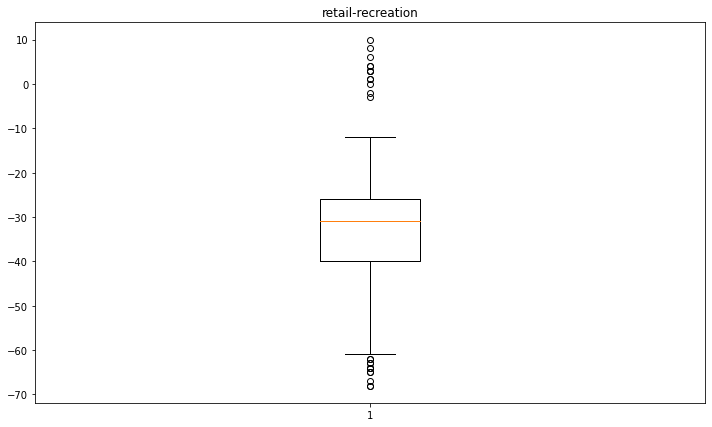

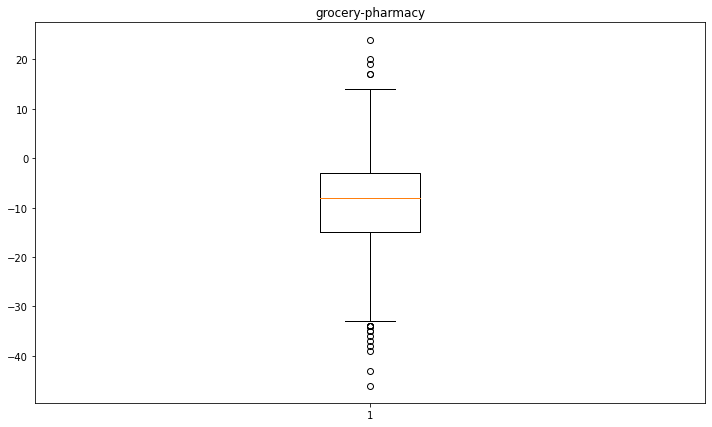

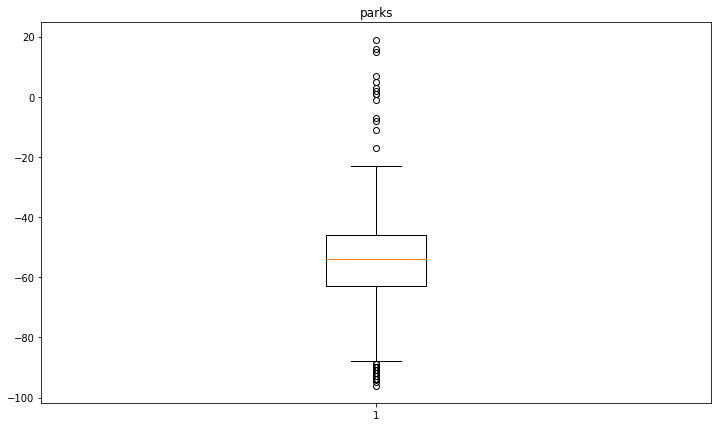

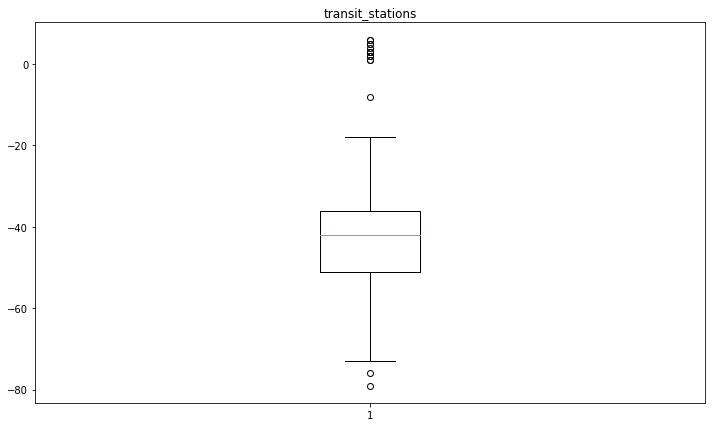

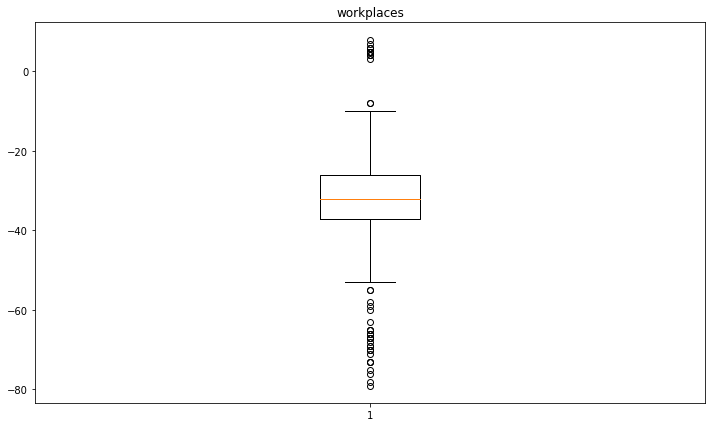

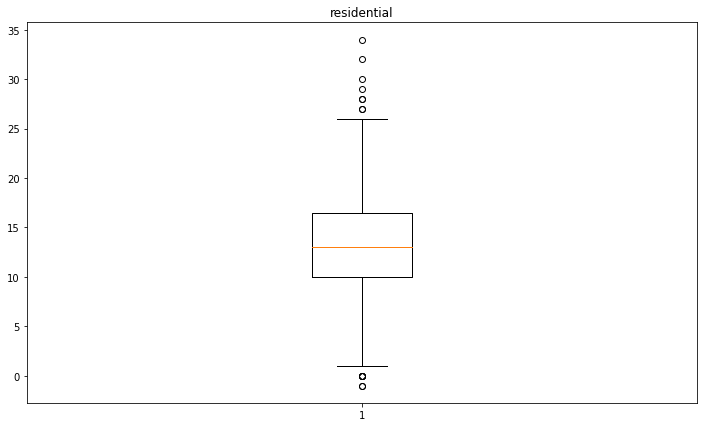

In [ ]:
for i in range (len(y)):
    plt.figure(figsize=(12, 7))
    plt.boxplot(df_concat[y[i]])
    plt.title(y[i])
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



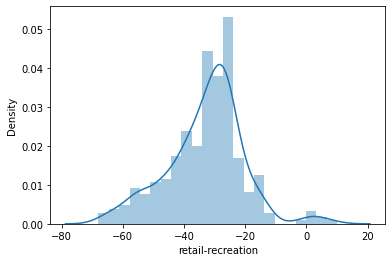

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



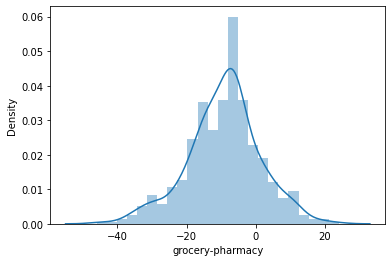

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



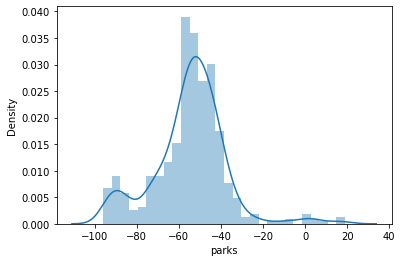

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



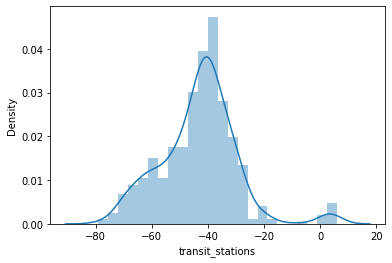

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



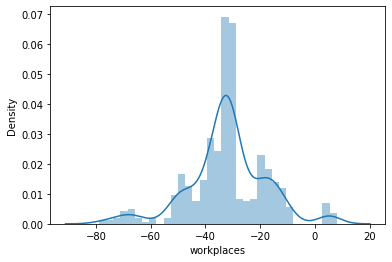

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



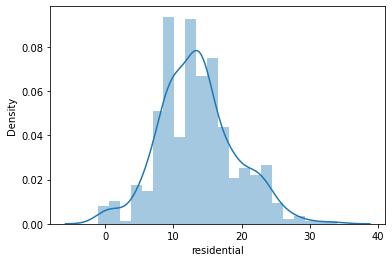

In [ ]:
for i in range (len(y)):
    sns.distplot(df_concat[y[i]])
    plt.show()

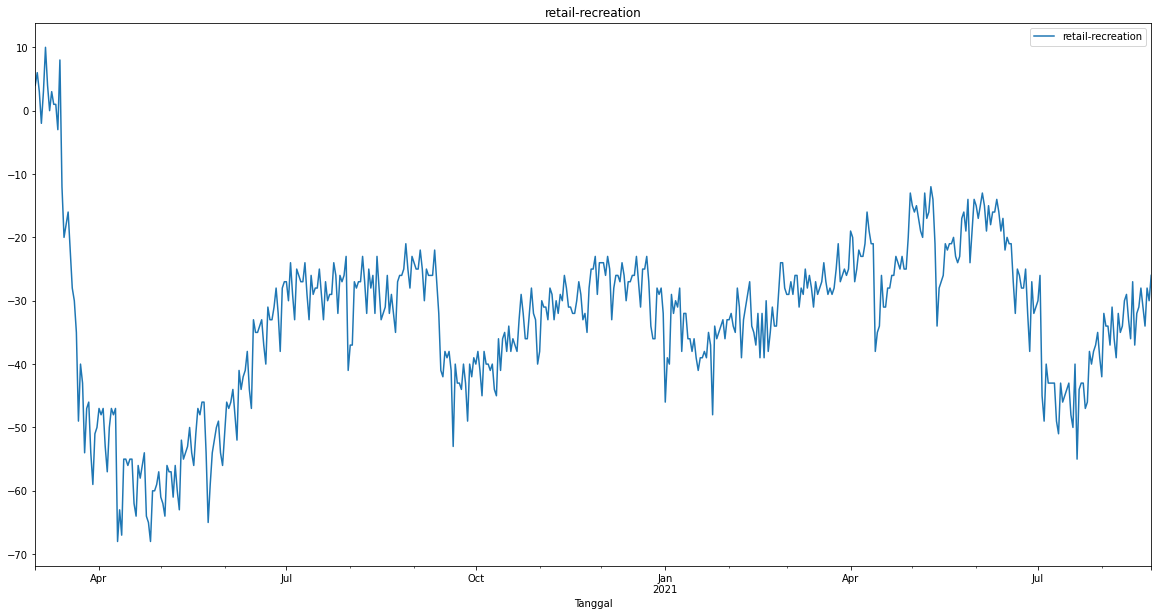

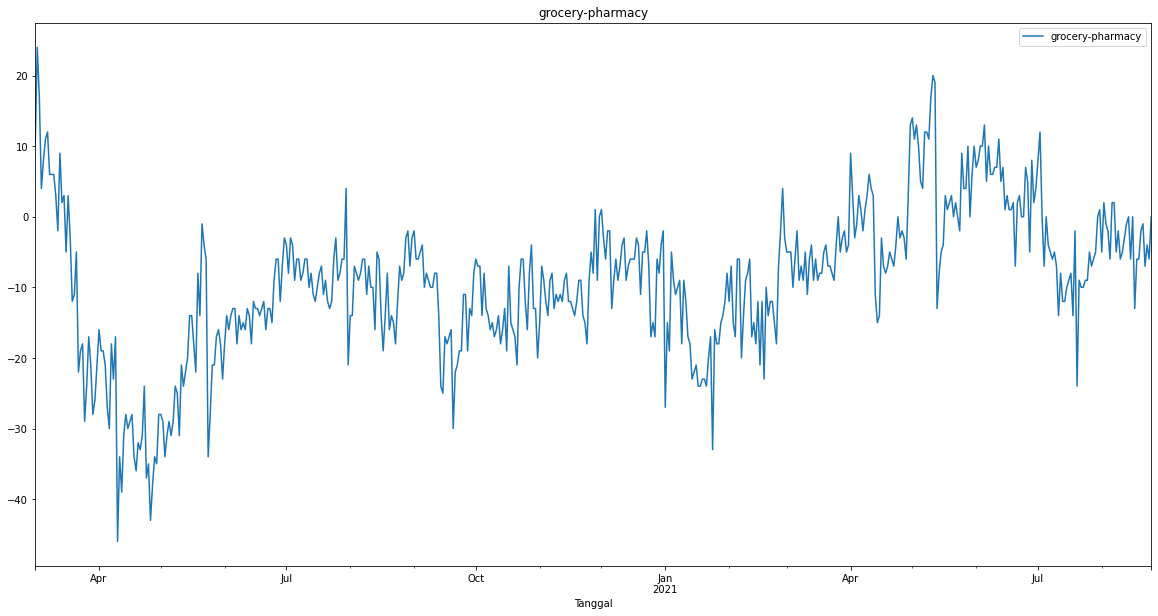

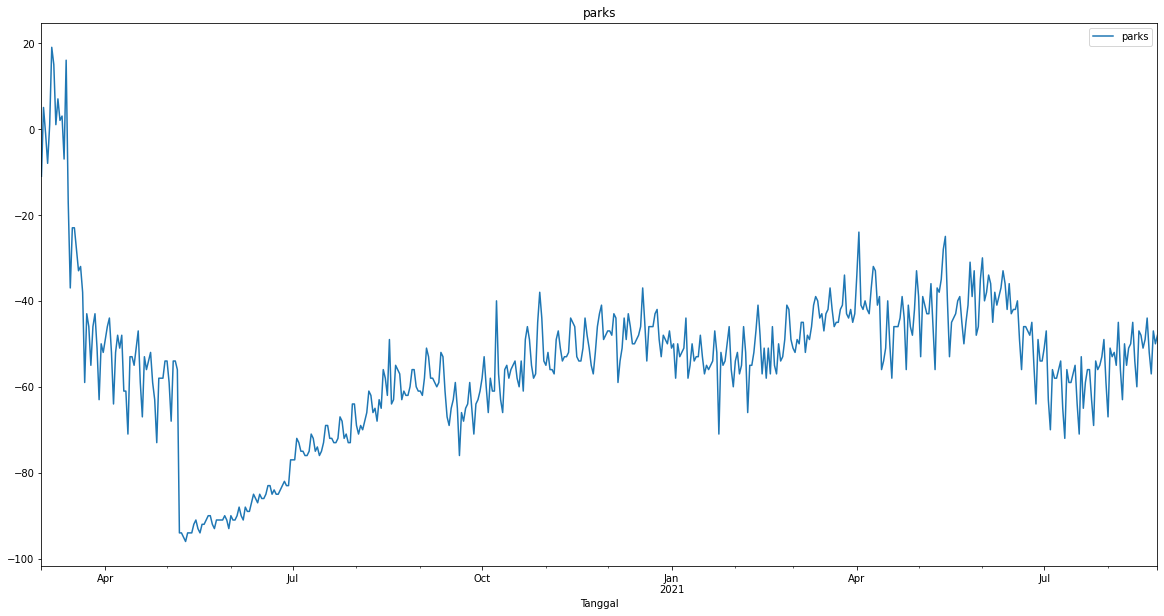

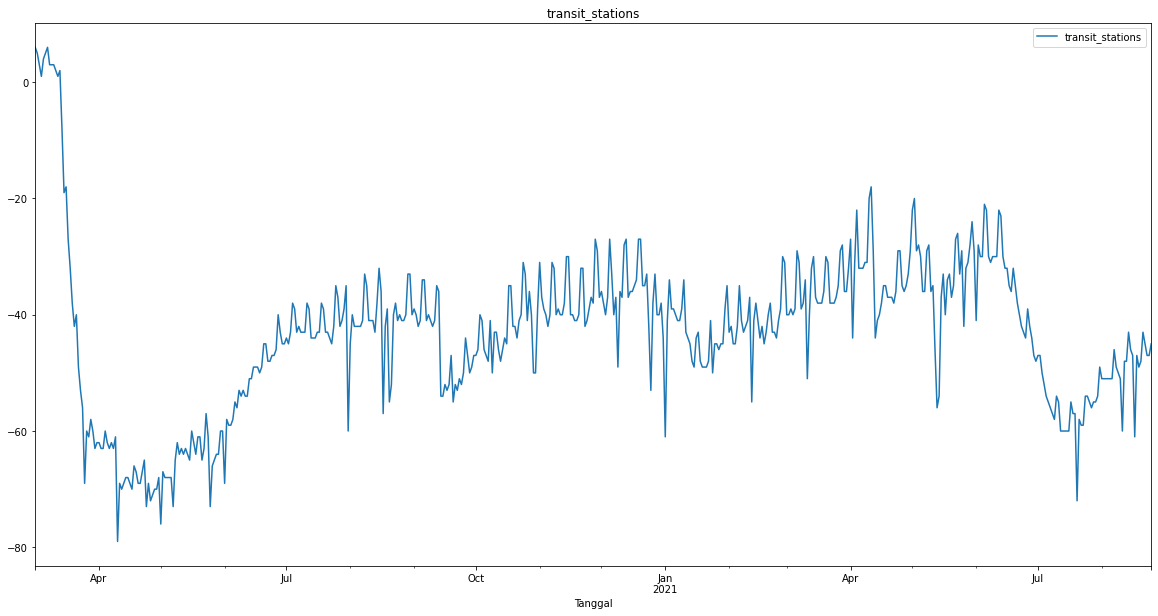

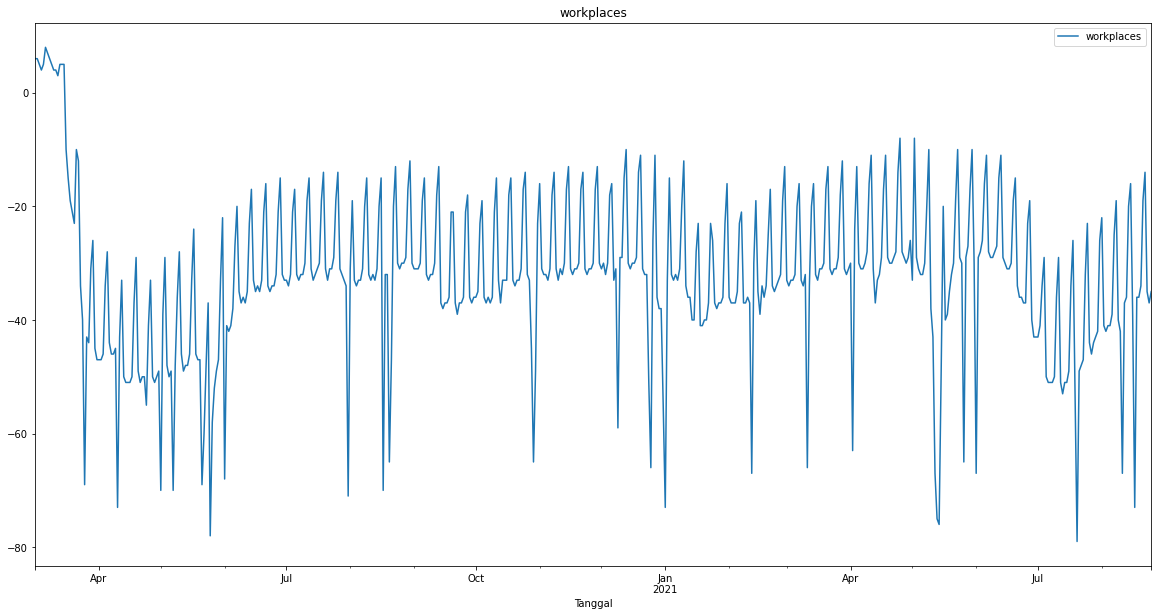

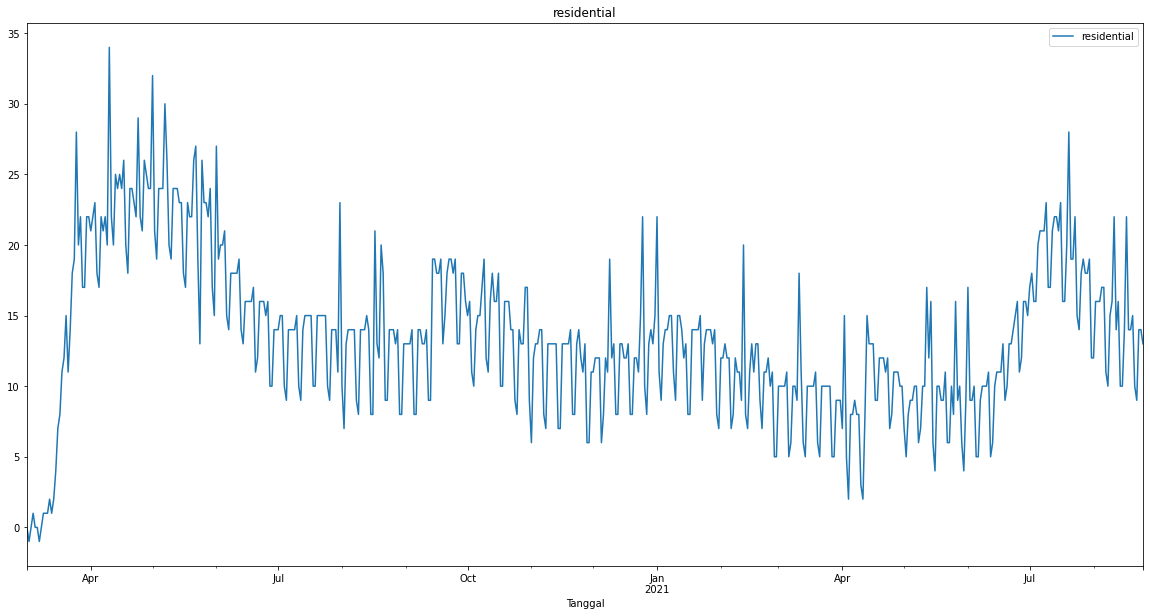

In [ ]:
for i in range (len(y)):
    df_concat.plot(kind="line", x="Tanggal", y=y[i], figsize=(20,10))
    plt.title(y[i])
    plt.show

### Place categories

<strong>Grocery & pharmacy</strong><br>
Mobility trends for places like grocery markets, food warehouses, farmers markets, specialty food shops, drug stores, and pharmacies.

<strong>Parks</strong><br>
Mobility trends for places like local parks, national parks, public beaches, marinas, dog parks, plazas, and public gardens.

<strong>Transit stations</strong><br>
Mobility trends for places like public transport hubs such as subway, bus, and train stations.

<strong>Retail & recreation</strong><br>
Mobility trends for places like restaurants, cafes, shopping centers, theme parks, museums, libraries, and movie theaters.

<strong>Residential</strong><br>
Mobility trends for places of residence.

<strong>Workplaces</strong><br>
Mobility trends for places of work.

## Data Agregat COVID Jakarta

In [ ]:
indo_jkt = pd.read_excel('/content/drive/MyDrive/Supraventricular tachycardia/Daily Update Data Agregat Covid-19 Jakarta.xlsx', 'Data Indonesia dan Jakarta')
indo_jkt.head()

,Tanggal,Positif (Indonesia),Dirawat (Indonesia),Sembuh (Indonesia),Meninggal (Indonesia),Meninggal (Jakarta),Sembuh (Jakarta),Self-Isolation (Jakarta),Dirawat (Jakarta),Positif (Jakarta),Positif Aktif (Jakarta),Positif Harian (Indonesia),Dirawat Harian (Indonesia),Sembuh Harian (Indonesia),Meninggal Harian (Indonesia),Meninggal Harian (Jakarta),Sembuh Harian (Jakarta),Self-Isolation Harian (Jakarta),Dirawat Harian (Jakarta),Positif Harian (Jakarta),Positif Aktif Harian (Jakarta)
0,2020-01-29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2020-03-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2020-03-02,2,2,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0
3,2020-03-03,2,2,0,0,1,0,0,2,3,2,0,0,0,0,1,0,0,2,3,2
4,2020-03-04,2,2,0,0,1,0,0,2,3,2,0,0,0,0,0,0,0,0,0,0


In [ ]:
indo_jkt.describe()

,Positif (Indonesia),Dirawat (Indonesia),Sembuh (Indonesia),Meninggal (Indonesia),Meninggal (Jakarta),Sembuh (Jakarta),Self-Isolation (Jakarta),Dirawat (Jakarta),Positif (Jakarta),Positif Aktif (Jakarta),Positif Harian (Indonesia),Dirawat Harian (Indonesia),Sembuh Harian (Indonesia),Meninggal Harian (Indonesia),Meninggal Harian (Jakarta),Sembuh Harian (Jakarta),Self-Isolation Harian (Jakarta),Dirawat Harian (Jakarta),Positif Harian (Jakarta),Positif Aktif Harian (Jakarta)
count,5.480000e+02,548.000000,5.480000e+02,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000
mean,9.566869e+05,110431.001825,8.186476e+05,27608.306569,3909.698905,214137.062044,9493.945255,4250.587591,231791.293796,13744.532847,7433.998175,397.062044,6796.200730,240.735401,24.182482,1512.478102,10.031022,4.116788,1550.808394,14.147810
std,1.053677e+06,125161.085848,9.176235e+05,29911.476128,3646.575183,233717.307289,14629.067355,4938.599518,246774.466325,19232.031667,10084.023497,4988.869806,9510.044929,380.035745,32.066309,2629.404934,1353.552416,556.654548,2305.276892,1703.266636
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-25725.000000,0.000000,0.000000,0.000000,0.000000,-11310.000000,-4253.000000,0.000000,-12107.000000
25%,7.971350e+04,36765.000000,3.869650e+04,3775.250000,718.500000,9672.750000,3210.750000,1951.500000,15108.250000,4731.250000,1603.000000,-351.250000,1160.500000,61.500000,7.000000,194.500000,-116.750000,-92.500000,283.250000,-120.500000
50%,5.311325e+05,70395.000000,4.438880e+05,16730.500000,2642.000000,122745.500000,5399.500000,2947.000000,135046.500000,8519.000000,4463.000000,236.000000,4129.500000,118.000000,16.000000,917.500000,24.000000,14.000000,926.000000,47.000000
75%,1.584726e+06,131635.750000,1.433482e+06,42947.750000,6492.750000,382222.500000,9393.000000,4463.500000,395111.500000,13070.000000,7450.000000,836.500000,7166.250000,197.250000,25.000000,1433.500000,196.500000,117.250000,1587.250000,216.000000
max,4.073831e+06,574135.000000,3.724318e+06,131923.000000,13252.000000,828838.000000,88295.000000,30418.000000,849843.000000,113138.000000,56757.000000,36726.000000,48832.000000,2069.000000,265.000000,20570.000000,7727.000000,2812.000000,14619.000000,9535.000000


In [ ]:
indo_jkt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   Tanggal                          548 non-null    datetime64[ns]
 1   Positif (Indonesia)              548 non-null    int64         
 2   Dirawat (Indonesia)              548 non-null    int64         
 3   Sembuh (Indonesia)               548 non-null    int64         
 4   Meninggal (Indonesia)            548 non-null    int64         
 5   Meninggal (Jakarta)              548 non-null    int64         
 6   Sembuh (Jakarta)                 548 non-null    int64         
 7   Self-Isolation (Jakarta)         548 non-null    int64         
 8   Dirawat (Jakarta)                548 non-null    int64         
 9   Positif (Jakarta)                548 non-null    int64         
 10  Positif Aktif (Jakarta)          548 non-null    int64        

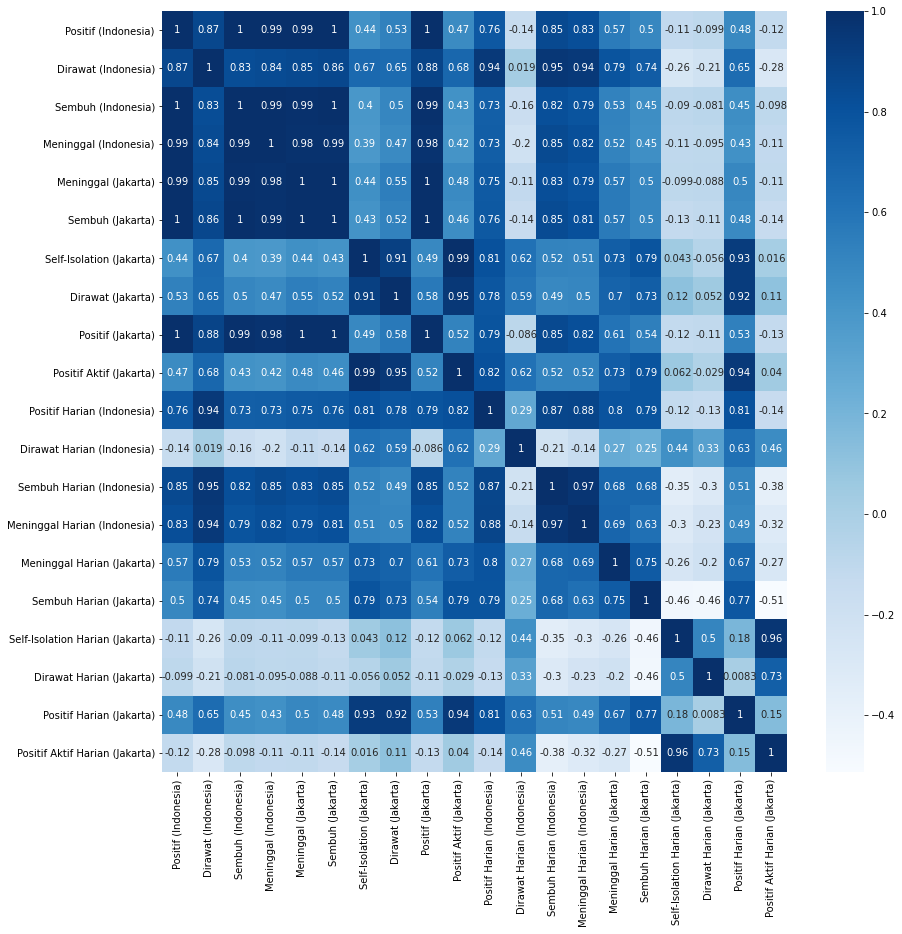

In [ ]:
plt.figure(figsize=(14,14))
sns.heatmap(indo_jkt.corr(),cmap='Blues',annot=True) 

In [ ]:
deathdaily_indo_jkt = indo_jkt[['Tanggal','Meninggal Harian (Jakarta)']]
deathdaily_indo_jkt

,Tanggal,Meninggal Harian (Jakarta)
0,2020-01-29,0
1,2020-03-01,0
2,2020-03-02,0
3,2020-03-03,1
4,2020-03-04,0
...,...,...
543,2021-08-25,11
544,2021-08-26,2
545,2021-08-27,16
546,2021-08-28,10


In [ ]:
deathdaily_indo_jkt.describe()

,Meninggal Harian (Jakarta)
count,548.000000
mean,24.182482
std,32.066309
min,0.000000
25%,7.000000
50%,16.000000
75%,25.000000
max,265.000000


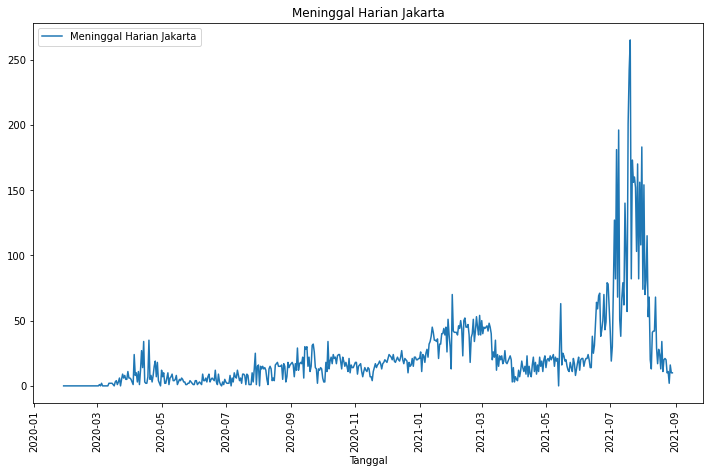

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(deathdaily_indo_jkt['Tanggal'], deathdaily_indo_jkt['Meninggal Harian (Jakarta)'], label ='Meninggal Harian Jakarta')
plt.title('Meninggal Harian Jakarta')
plt.xlabel('Tanggal')
plt.xticks(rotation=90)
plt.legend()
plt.show()

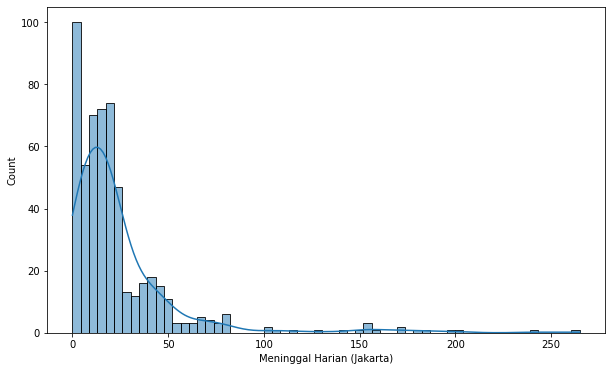

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(deathdaily_indo_jkt['Meninggal Harian (Jakarta)'],kde=True) 

In [ ]:
suspek_jkt = pd.read_excel('/content/drive/MyDrive/Supraventricular tachycardia/Daily Update Data Agregat Covid-19 Jakarta.xlsx', 'Data Suspek dll (Jakarta)')

In [ ]:
suspek_jkt = suspek_jkt[['Tanggal','Isolasi di Rumah (Kontak Erat)', 'Selesai Isolasi (Kontak Erat)', 'Total Pelaku Perjalanan']]

In [ ]:
suspek_jkt.head()

,Tanggal,Isolasi di Rumah (Kontak Erat),Selesai Isolasi (Kontak Erat),Total Pelaku Perjalanan
0,2020-07-17,5191,73534,1794
1,2020-07-18,6531,73851,1803
2,2020-07-19,7372,73955,1803
3,2020-07-20,5547,76192,1809
4,2020-07-21,5934,76926,1824


In [ ]:
suspek_jkt.shape

(409, 4)

In [ ]:
#Membuat dataframe berisi angka vaksinasi 1 dan 2 di Jakarta
vax_jkt = pd.read_excel('/content/drive/MyDrive/Supraventricular tachycardia/Daily Update Data Agregat Covid-19 Jakarta.xlsx', sheet_name='Vaksinasi', skiprows=4, usecols= 'A, R:S')
vax_jkt.columns = ['Tanggal', 'Vaksinasi 1 Jakarta', 'Vaksinasi 2 Jakarta']
vax_jkt

,Tanggal,Vaksinasi 1 Jakarta,Vaksinasi 2 Jakarta
0,2021-03-05,281997,91078
1,2021-03-06,289951,91379
2,2021-03-07,334506,93974
3,2021-03-08,361710,96978
4,2021-03-09,423139,119854
...,...,...,...
173,2021-08-25,9457611,5088010
174,2021-08-26,9505680,5197381
175,2021-08-27,9554298,5317949
176,2021-08-28,9622701,5490891


In [ ]:
#Membuat dataframe berisi angka vaksinasi harian di Jakarta
vax_jkt['Vaksin 1 Jakarta shifted'] = vax_jkt['Vaksinasi 1 Jakarta'].shift(1)
vax_jkt['Vaksin 2 Jakarta shifted'] = vax_jkt['Vaksinasi 2 Jakarta'].shift(1)
vax_jkt

,Tanggal,Vaksinasi 1 Jakarta,Vaksinasi 2 Jakarta,Vaksin 1 Jakarta shifted,Vaksin 2 Jakarta shifted
0,2021-03-05,281997,91078,NaN,NaN
1,2021-03-06,289951,91379,281997.0,91078.0
2,2021-03-07,334506,93974,289951.0,91379.0
3,2021-03-08,361710,96978,334506.0,93974.0
4,2021-03-09,423139,119854,361710.0,96978.0
...,...,...,...,...,...
173,2021-08-25,9457611,5088010,9409218.0,4978587.0
174,2021-08-26,9505680,5197381,9457611.0,5088010.0
175,2021-08-27,9554298,5317949,9505680.0,5197381.0
176,2021-08-28,9622701,5490891,9554298.0,5317949.0


In [ ]:
vax_jkt['Vaksinasi 1 Jakarta'] = vax_jkt['Vaksinasi 1 Jakarta']-vax_jkt['Vaksin 1 Jakarta shifted']
vax_jkt['Vaksinasi 2 Jakarta'] = vax_jkt['Vaksinasi 2 Jakarta']-vax_jkt['Vaksin 2 Jakarta shifted']
vax_jkt_harian = vax_jkt.drop(['Vaksin 1 Jakarta shifted', 'Vaksin 2 Jakarta shifted'], axis=1)
vax_jkt_harian.columns = ['Tanggal','Vaksinasi 1 Jakarta Harian', 'Vaksinasi 2 Jakarta Harian']
vax_jkt_harian

,Tanggal,Vaksinasi 1 Jakarta Harian,Vaksinasi 2 Jakarta Harian
0,2021-03-05,NaN,NaN
1,2021-03-06,7954.0,301.0
2,2021-03-07,44555.0,2595.0
3,2021-03-08,27204.0,3004.0
4,2021-03-09,61429.0,22876.0
...,...,...,...
173,2021-08-25,48393.0,109423.0
174,2021-08-26,48069.0,109371.0
175,2021-08-27,48618.0,120568.0
176,2021-08-28,68403.0,172942.0


In [ ]:
deathdaily_indo_jkt = deathdaily_indo_jkt.drop([0])
deathdaily_indo_jkt

,Tanggal,Meninggal Harian (Jakarta)
1,2020-03-01,0
2,2020-03-02,0
3,2020-03-03,1
4,2020-03-04,0
5,2020-03-05,2
...,...,...
543,2021-08-25,11
544,2021-08-26,2
545,2021-08-27,16
546,2021-08-28,10


In [ ]:
vax_jkt_harian.shape

(178, 3)

In [ ]:
suspek_jkt.shape

(409, 4)

In [ ]:
data_jakarta.shape

(547, 6)

In [ ]:
data_jakarta

,Tanggal,Self Isolation,Masih Perawatan,Sembuh Harian,Positif Harian,Jumlah Pasien Harian
0,2020-03-01,0,0,0,0,0.0
1,2020-03-02,0,0,0,0,0.0
2,2020-03-03,0,2,0,3,3.0
3,2020-03-04,0,2,0,0,0.0
4,2020-03-05,0,4,0,4,4.0
...,...,...,...,...,...,...
542,2021-08-25,5442,2731,729,789,789.0
543,2021-08-26,5110,2604,1031,574,574.0
544,2021-08-27,5491,2504,341,638,638.0
545,2021-08-28,5607,2395,451,468,468.0


In [ ]:
data_jakarta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Tanggal               547 non-null    datetime64[ns]
 1   Self Isolation        547 non-null    int64         
 2   Masih Perawatan       547 non-null    int64         
 3   Sembuh Harian         547 non-null    int64         
 4   Positif Harian        547 non-null    int64         
 5   Jumlah Pasien Harian  547 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 25.8 KB


In [ ]:
deathdaily_indo_jkt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547 entries, 1 to 547
Data columns (total 2 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Tanggal                     547 non-null    datetime64[ns]
 1   Meninggal Harian (Jakarta)  547 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 12.8 KB


## Merge data mobilitas, data COVID, data kematian harian, dan data vaksinasi Jakarta

In [ ]:
main_df = data_jakarta.merge(deathdaily_indo_jkt, on='Tanggal')
main_df

,Tanggal,Self Isolation,Masih Perawatan,Sembuh Harian,Positif Harian,Jumlah Pasien Harian,Meninggal Harian (Jakarta)
0,2020-03-01,0,0,0,0,0.0,0
1,2020-03-02,0,0,0,0,0.0,0
2,2020-03-03,0,2,0,3,3.0,1
3,2020-03-04,0,2,0,0,0.0,0
4,2020-03-05,0,4,0,4,4.0,2
...,...,...,...,...,...,...,...
542,2021-08-25,5442,2731,729,789,789.0,11
543,2021-08-26,5110,2604,1031,574,574.0,2
544,2021-08-27,5491,2504,341,638,638.0,16
545,2021-08-28,5607,2395,451,468,468.0,10


In [ ]:
main_df = main_df.merge(vax_jkt_harian, how = 'outer', on='Tanggal')
main_df

,Tanggal,Self Isolation,Masih Perawatan,Sembuh Harian,Positif Harian,Jumlah Pasien Harian,Meninggal Harian (Jakarta),Vaksinasi 1 Jakarta Harian,Vaksinasi 2 Jakarta Harian
0,2020-03-01,0,0,0,0,0.0,0,NaN,NaN
1,2020-03-02,0,0,0,0,0.0,0,NaN,NaN
2,2020-03-03,0,2,0,3,3.0,1,NaN,NaN
3,2020-03-04,0,2,0,0,0.0,0,NaN,NaN
4,2020-03-05,0,4,0,4,4.0,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...
542,2021-08-25,5442,2731,729,789,789.0,11,48393.0,109423.0
543,2021-08-26,5110,2604,1031,574,574.0,2,48069.0,109371.0
544,2021-08-27,5491,2504,341,638,638.0,16,48618.0,120568.0
545,2021-08-28,5607,2395,451,468,468.0,10,68403.0,172942.0


In [ ]:
suspek_jkt

,Tanggal,Isolasi di Rumah (Kontak Erat),Selesai Isolasi (Kontak Erat),Total Pelaku Perjalanan
0,2020-07-17,5191,73534,1794
1,2020-07-18,6531,73851,1803
2,2020-07-19,7372,73955,1803
3,2020-07-20,5547,76192,1809
4,2020-07-21,5934,76926,1824
...,...,...,...,...
404,2021-08-25,8672,1747382,204553
405,2021-08-26,10253,1748902,207437
406,2021-08-27,10704,1750567,209815
407,2021-08-28,12455,1750996,212964


In [ ]:
main_df = main_df.merge(suspek_jkt, how = 'outer', on='Tanggal')
main_df

,Tanggal,Self Isolation,Masih Perawatan,Sembuh Harian,Positif Harian,Jumlah Pasien Harian,Meninggal Harian (Jakarta),Vaksinasi 1 Jakarta Harian,Vaksinasi 2 Jakarta Harian,Isolasi di Rumah (Kontak Erat),Selesai Isolasi (Kontak Erat),Total Pelaku Perjalanan
0,2020-03-01,0,0,0,0,0.0,0,NaN,NaN,NaN,NaN,NaN
1,2020-03-02,0,0,0,0,0.0,0,NaN,NaN,NaN,NaN,NaN
2,2020-03-03,0,2,0,3,3.0,1,NaN,NaN,NaN,NaN,NaN
3,2020-03-04,0,2,0,0,0.0,0,NaN,NaN,NaN,NaN,NaN
4,2020-03-05,0,4,0,4,4.0,2,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
542,2021-08-25,5442,2731,729,789,789.0,11,48393.0,109423.0,8672.0,1747382.0,204553.0
543,2021-08-26,5110,2604,1031,574,574.0,2,48069.0,109371.0,10253.0,1748902.0,207437.0
544,2021-08-27,5491,2504,341,638,638.0,16,48618.0,120568.0,10704.0,1750567.0,209815.0
545,2021-08-28,5607,2395,451,468,468.0,10,68403.0,172942.0,12455.0,1750996.0,212964.0


In [ ]:
#drop row tanggal 26 hingga 29 agustus untuk menyesuaikan dengan data mobility
main_df = main_df.drop([546, 545, 544, 543])
main_df

,Tanggal,Self Isolation,Masih Perawatan,Sembuh Harian,Positif Harian,Jumlah Pasien Harian,Meninggal Harian (Jakarta),Vaksinasi 1 Jakarta Harian,Vaksinasi 2 Jakarta Harian,Isolasi di Rumah (Kontak Erat),Selesai Isolasi (Kontak Erat),Total Pelaku Perjalanan
0,2020-03-01,0,0,0,0,0.0,0,NaN,NaN,NaN,NaN,NaN
1,2020-03-02,0,0,0,0,0.0,0,NaN,NaN,NaN,NaN,NaN
2,2020-03-03,0,2,0,3,3.0,1,NaN,NaN,NaN,NaN,NaN
3,2020-03-04,0,2,0,0,0.0,0,NaN,NaN,NaN,NaN,NaN
4,2020-03-05,0,4,0,4,4.0,2,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
538,2021-08-21,5565,3199,915,891,891.0,20,34136.0,83463.0,8013.0,1743757.0,194384.0
539,2021-08-22,5584,2947,913,701,701.0,21,31902.0,82364.0,8939.0,1744217.0,196664.0
540,2021-08-23,5477,2788,731,485,485.0,20,12815.0,34300.0,8023.0,1745880.0,199630.0
541,2021-08-24,5277,2847,615,484,484.0,10,45310.0,99016.0,7684.0,1747020.0,201676.0


In [ ]:
main_df = main_df.merge(df_concat, how = 'outer', on='Tanggal')
main_df

,Tanggal,Self Isolation,Masih Perawatan,Sembuh Harian,Positif Harian,Jumlah Pasien Harian,Meninggal Harian (Jakarta),Vaksinasi 1 Jakarta Harian,Vaksinasi 2 Jakarta Harian,Isolasi di Rumah (Kontak Erat),Selesai Isolasi (Kontak Erat),Total Pelaku Perjalanan,retail-recreation,grocery-pharmacy,parks,transit_stations,workplaces,residential
0,2020-03-01,0,0,0,0,0.0,0,NaN,NaN,NaN,NaN,NaN,4.0,10.0,-11.0,6.0,6.0,0.0
1,2020-03-02,0,0,0,0,0.0,0,NaN,NaN,NaN,NaN,NaN,6.0,24.0,5.0,5.0,6.0,-1.0
2,2020-03-03,0,2,0,3,3.0,1,NaN,NaN,NaN,NaN,NaN,3.0,17.0,-1.0,3.0,5.0,0.0
3,2020-03-04,0,2,0,0,0.0,0,NaN,NaN,NaN,NaN,NaN,-2.0,4.0,-8.0,1.0,4.0,1.0
4,2020-03-05,0,4,0,4,4.0,2,NaN,NaN,NaN,NaN,NaN,3.0,8.0,1.0,4.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,2021-08-21,5565,3199,915,891,891.0,20,34136.0,83463.0,8013.0,1743757.0,194384.0,-31.0,-1.0,-52.0,-43.0,-19.0,10.0
539,2021-08-22,5584,2947,913,701,701.0,21,31902.0,82364.0,8939.0,1744217.0,196664.0,-34.0,-7.0,-57.0,-45.0,-14.0,9.0
540,2021-08-23,5477,2788,731,485,485.0,20,12815.0,34300.0,8023.0,1745880.0,199630.0,-28.0,-4.0,-47.0,-47.0,-35.0,14.0
541,2021-08-24,5277,2847,615,484,484.0,10,45310.0,99016.0,7684.0,1747020.0,201676.0,-30.0,-6.0,-50.0,-47.0,-37.0,14.0


## Impute Missing Values

In [ ]:
main_df.isnull().sum()

Tanggal                             0
Self Isolation                      0
Masih Perawatan                     0
Sembuh Harian                       0
Positif Harian                      0
Jumlah Pasien Harian                0
Meninggal Harian (Jakarta)          0
Vaksinasi 1 Jakarta Harian        370
Vaksinasi 2 Jakarta Harian        370
Isolasi di Rumah (Kontak Erat)    138
Selesai Isolasi (Kontak Erat)     138
Total Pelaku Perjalanan           138
retail-recreation                   0
grocery-pharmacy                    0
parks                               0
transit_stations                    0
workplaces                          0
residential                         0
dtype: int64

In [ ]:
main_df['Vaksinasi 1 Jakarta Harian'] = main_df['Vaksinasi 1 Jakarta Harian'].replace(np.nan, 0)
main_df['Vaksinasi 2 Jakarta Harian'] = main_df['Vaksinasi 2 Jakarta Harian'].replace(np.nan, 0)
main_df['Isolasi di Rumah (Kontak Erat)'] = main_df['Isolasi di Rumah (Kontak Erat)'].replace(np.nan, 0)
main_df['Selesai Isolasi (Kontak Erat)'] = main_df['Selesai Isolasi (Kontak Erat)'].replace(np.nan, 0)
main_df['Total Pelaku Perjalanan'] = main_df['Total Pelaku Perjalanan'].replace(np.nan, main_df['Total Pelaku Perjalanan'].median())

In [ ]:
main_df

,Tanggal,Self Isolation,Masih Perawatan,Sembuh Harian,Positif Harian,Jumlah Pasien Harian,Meninggal Harian (Jakarta),Vaksinasi 1 Jakarta Harian,Vaksinasi 2 Jakarta Harian,Isolasi di Rumah (Kontak Erat),Selesai Isolasi (Kontak Erat),Total Pelaku Perjalanan,retail-recreation,grocery-pharmacy,parks,transit_stations,workplaces,residential
0,2020-03-01,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,4056.0,4.0,10.0,-11.0,6.0,6.0,0.0
1,2020-03-02,0,0,0,0,0.0,0,0.0,0.0,0.0,0.0,4056.0,6.0,24.0,5.0,5.0,6.0,-1.0
2,2020-03-03,0,2,0,3,3.0,1,0.0,0.0,0.0,0.0,4056.0,3.0,17.0,-1.0,3.0,5.0,0.0
3,2020-03-04,0,2,0,0,0.0,0,0.0,0.0,0.0,0.0,4056.0,-2.0,4.0,-8.0,1.0,4.0,1.0
4,2020-03-05,0,4,0,4,4.0,2,0.0,0.0,0.0,0.0,4056.0,3.0,8.0,1.0,4.0,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538,2021-08-21,5565,3199,915,891,891.0,20,34136.0,83463.0,8013.0,1743757.0,194384.0,-31.0,-1.0,-52.0,-43.0,-19.0,10.0
539,2021-08-22,5584,2947,913,701,701.0,21,31902.0,82364.0,8939.0,1744217.0,196664.0,-34.0,-7.0,-57.0,-45.0,-14.0,9.0
540,2021-08-23,5477,2788,731,485,485.0,20,12815.0,34300.0,8023.0,1745880.0,199630.0,-28.0,-4.0,-47.0,-47.0,-35.0,14.0
541,2021-08-24,5277,2847,615,484,484.0,10,45310.0,99016.0,7684.0,1747020.0,201676.0,-30.0,-6.0,-50.0,-47.0,-37.0,14.0


In [ ]:
main_df.set_index('Tanggal', inplace=True)

In [ ]:
main_df = main_df.astype(int)

In [ ]:
main_df

,Self Isolation,Masih Perawatan,Sembuh Harian,Positif Harian,Jumlah Pasien Harian,Meninggal Harian (Jakarta),Vaksinasi 1 Jakarta Harian,Vaksinasi 2 Jakarta Harian,Isolasi di Rumah (Kontak Erat),Selesai Isolasi (Kontak Erat),Total Pelaku Perjalanan,retail-recreation,grocery-pharmacy,parks,transit_stations,workplaces,residential
Tanggal,,,,,,,,,,,,,,,,,
2020-03-01,0,0,0,0,0,0,0,0,0,0,4056,4,10,-11,6,6,0
2020-03-02,0,0,0,0,0,0,0,0,0,0,4056,6,24,5,5,6,-1
2020-03-03,0,2,0,3,3,1,0,0,0,0,4056,3,17,-1,3,5,0
2020-03-04,0,2,0,0,0,0,0,0,0,0,4056,-2,4,-8,1,4,1
2020-03-05,0,4,0,4,4,2,0,0,0,0,4056,3,8,1,4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-21,5565,3199,915,891,891,20,34136,83463,8013,1743757,194384,-31,-1,-52,-43,-19,10
2021-08-22,5584,2947,913,701,701,21,31902,82364,8939,1744217,196664,-34,-7,-57,-45,-14,9
2021-08-23,5477,2788,731,485,485,20,12815,34300,8023,1745880,199630,-28,-4,-47,-47,-35,14


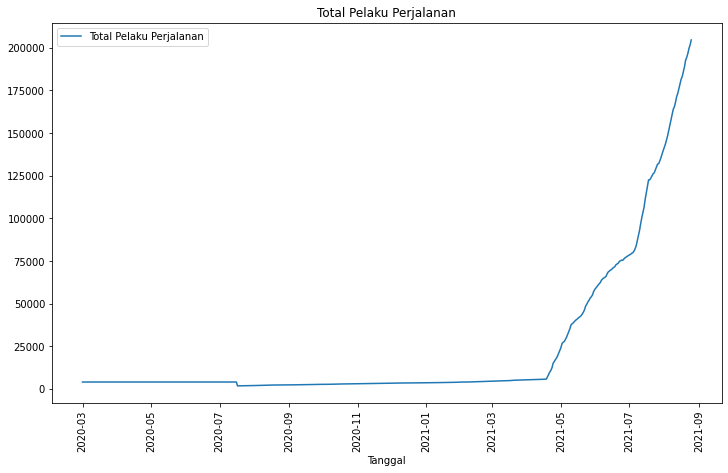

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(main_df.index, main_df['Total Pelaku Perjalanan'], label ='Total Pelaku Perjalanan')
plt.title('Total Pelaku Perjalanan')
plt.xlabel('Tanggal')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [ ]:
main_df['Total Pelaku Perjalanan'].describe()

count       543.000000
mean      23572.458564
std       44138.191615
min        1794.000000
25%        3362.000000
50%        4056.000000
75%        5587.500000
max      204553.000000
Name: Total Pelaku Perjalanan, dtype: float64

# Save to CSV

In [ ]:
main_df.to_csv('/content/drive/MyDrive/Supraventricular tachycardia/Data Covid Jakarta.csv')

# Classification

In [ ]:
print(main_df['Positif Harian'].min())
print(main_df['Positif Harian'].max())
main_df.drop('Jumlah Pasien Harian', inplace=True, axis=1)

0
14619


In [ ]:
conditions = [
    (main_df['Positif Harian'] <= 5500),
    (main_df['Positif Harian'] > 5500)
    ]

# create a list of the values we want to assign for each condition
values = [0, 1]

# create a new column and use np.select to assign values to it using our lists as arguments
main_df_positif = main_df.copy()
main_df_positif['Positif Harian'] = np.select(conditions, values)
main_df_positif

,Self Isolation,Masih Perawatan,Sembuh Harian,Positif Harian,Meninggal Harian (Jakarta),Vaksinasi 1 Jakarta Harian,Vaksinasi 2 Jakarta Harian,Isolasi di Rumah (Kontak Erat),Selesai Isolasi (Kontak Erat),Total Pelaku Perjalanan,retail-recreation,grocery-pharmacy,parks,transit_stations,workplaces,residential
Tanggal,,,,,,,,,,,,,,,,
2020-03-01,0,0,0,0,0,0,0,0,0,4056,4,10,-11,6,6,0
2020-03-02,0,0,0,0,0,0,0,0,0,4056,6,24,5,5,6,-1
2020-03-03,0,2,0,0,1,0,0,0,0,4056,3,17,-1,3,5,0
2020-03-04,0,2,0,0,0,0,0,0,0,4056,-2,4,-8,1,4,1
2020-03-05,0,4,0,0,2,0,0,0,0,4056,3,8,1,4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-21,5565,3199,915,0,20,34136,83463,8013,1743757,194384,-31,-1,-52,-43,-19,10
2021-08-22,5584,2947,913,0,21,31902,82364,8939,1744217,196664,-34,-7,-57,-45,-14,9
2021-08-23,5477,2788,731,0,20,12815,34300,8023,1745880,199630,-28,-4,-47,-47,-35,14


In [ ]:
main_df_positif['Positif Harian'].value_counts()

0    511
1     32
Name: Positif Harian, dtype: int64

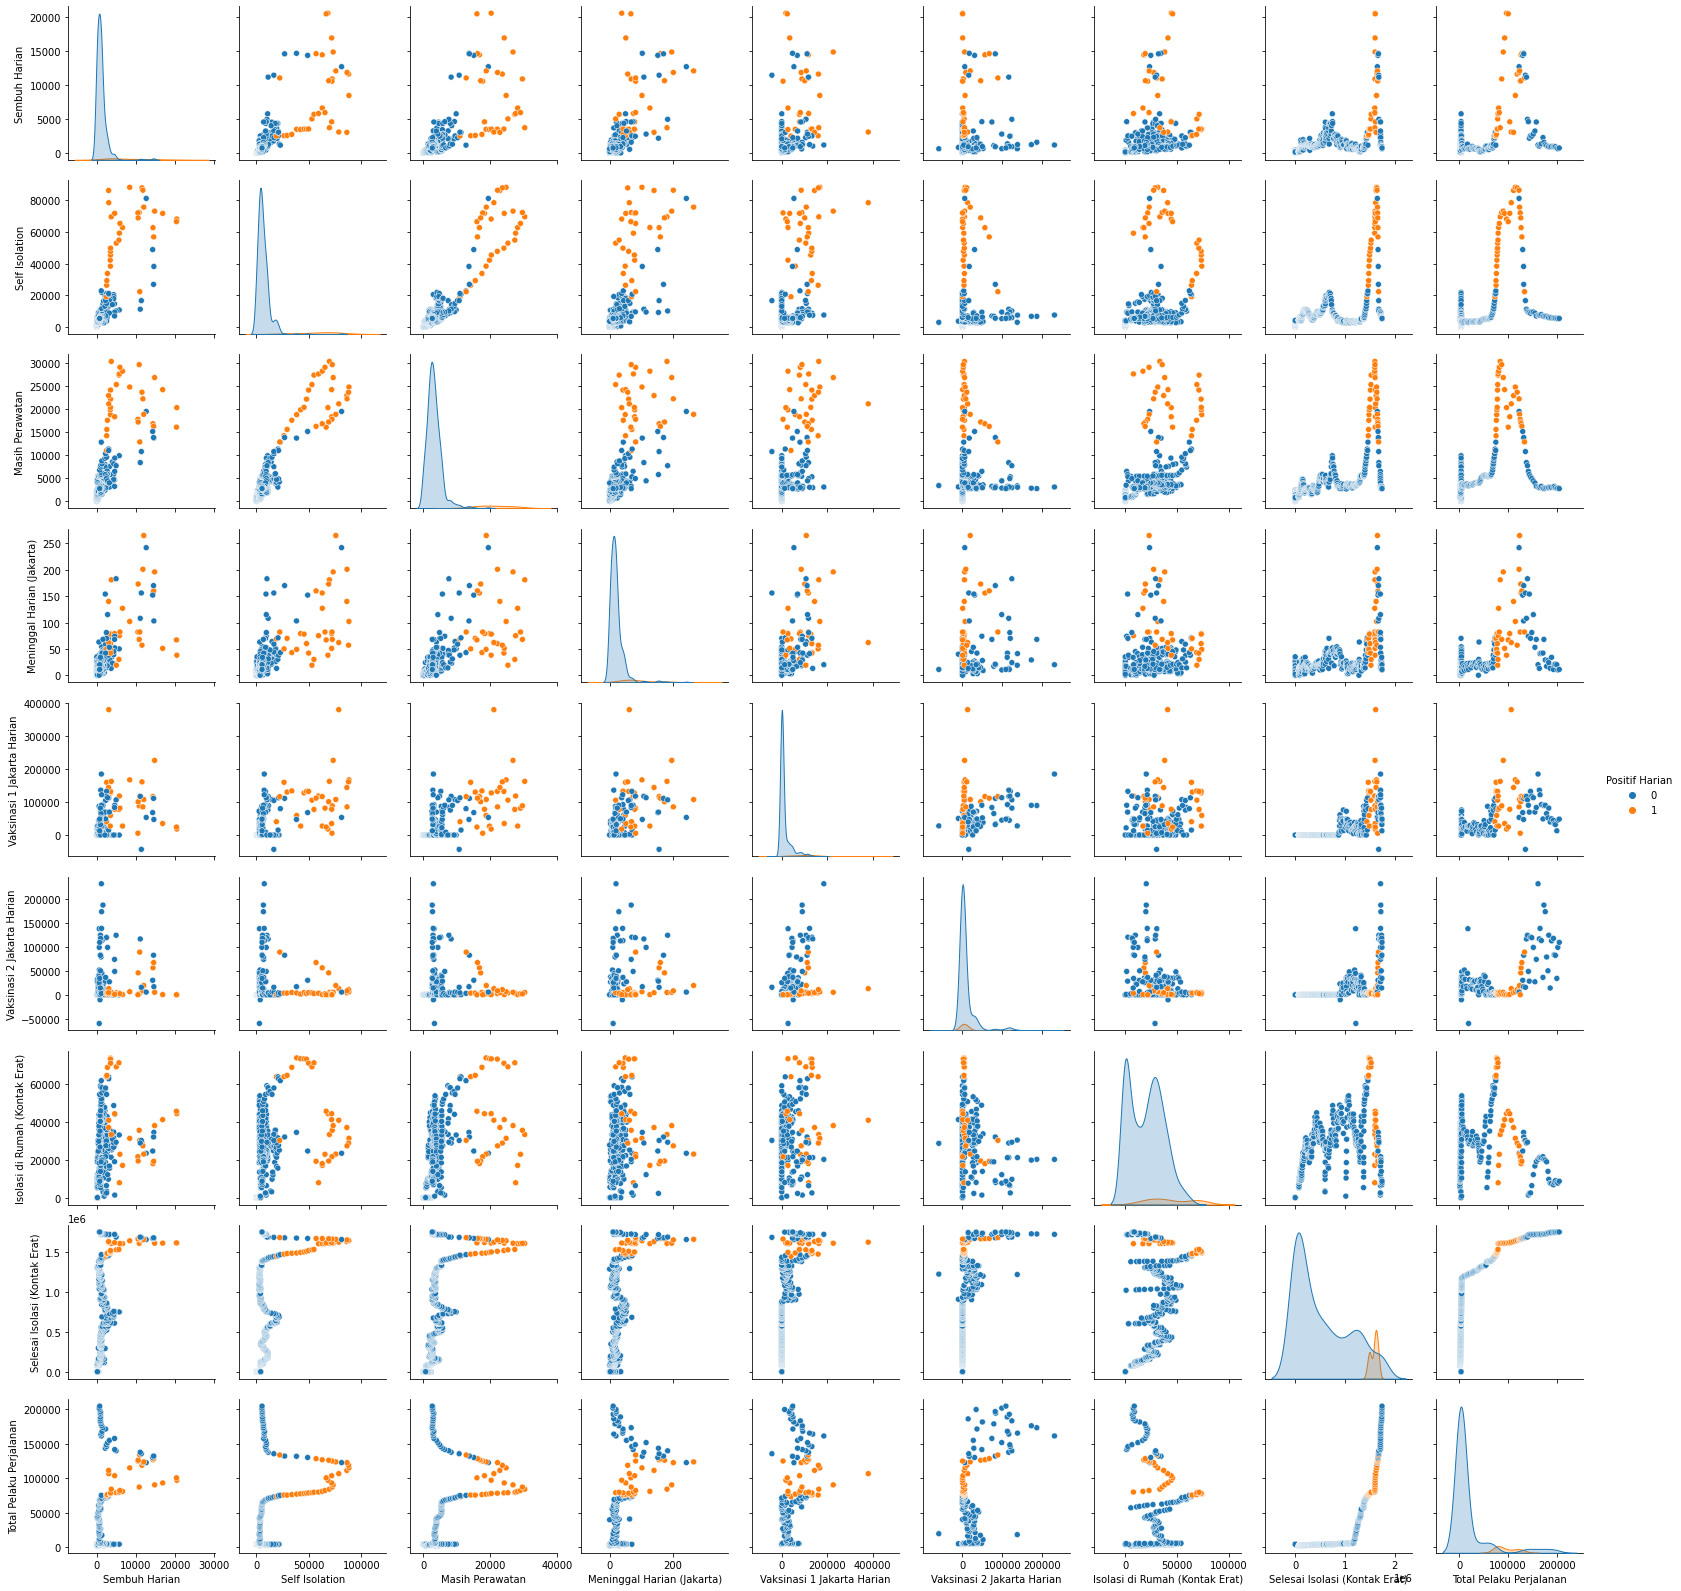

In [ ]:
main_df_new_pos = main_df_positif[['Sembuh Harian', 'Positif Harian', 'Self Isolation', 'Masih Perawatan', 'Meninggal Harian (Jakarta)', 'Vaksinasi 1 Jakarta Harian', 'Vaksinasi 2 Jakarta Harian', 'Isolasi di Rumah (Kontak Erat)', 'Selesai Isolasi (Kontak Erat)', 'Total Pelaku Perjalanan']]
sns.pairplot(main_df_new_pos, hue='Positif Harian')
plt.show()

In [ ]:
print(main_df['Meninggal Harian (Jakarta)'].min())
print(main_df['Meninggal Harian (Jakarta)'].max())

0
265


In [ ]:
conditions = [
    (main_df['Meninggal Harian (Jakarta)'] <= 220),
    (main_df['Meninggal Harian (Jakarta)'] > 220)
    ]

# create a list of the values we want to assign for each condition
values = [0, 1]

# create a new column and use np.select to assign values to it using our lists as arguments
main_df_meninggal = main_df.copy()
main_df_meninggal['Meninggal Harian (Jakarta)'] = np.select(conditions, values)
main_df_meninggal

,Self Isolation,Masih Perawatan,Sembuh Harian,Positif Harian,Meninggal Harian (Jakarta),Vaksinasi 1 Jakarta Harian,Vaksinasi 2 Jakarta Harian,Isolasi di Rumah (Kontak Erat),Selesai Isolasi (Kontak Erat),Total Pelaku Perjalanan,retail-recreation,grocery-pharmacy,parks,transit_stations,workplaces,residential
Tanggal,,,,,,,,,,,,,,,,
2020-03-01,0,0,0,0,0,0,0,0,0,4056,4,10,-11,6,6,0
2020-03-02,0,0,0,0,0,0,0,0,0,4056,6,24,5,5,6,-1
2020-03-03,0,2,0,3,0,0,0,0,0,4056,3,17,-1,3,5,0
2020-03-04,0,2,0,0,0,0,0,0,0,4056,-2,4,-8,1,4,1
2020-03-05,0,4,0,4,0,0,0,0,0,4056,3,8,1,4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-21,5565,3199,915,891,0,34136,83463,8013,1743757,194384,-31,-1,-52,-43,-19,10
2021-08-22,5584,2947,913,701,0,31902,82364,8939,1744217,196664,-34,-7,-57,-45,-14,9
2021-08-23,5477,2788,731,485,0,12815,34300,8023,1745880,199630,-28,-4,-47,-47,-35,14


In [ ]:
main_df_meninggal['Meninggal Harian (Jakarta)'].value_counts()

0    541
1      2
Name: Meninggal Harian (Jakarta), dtype: int64

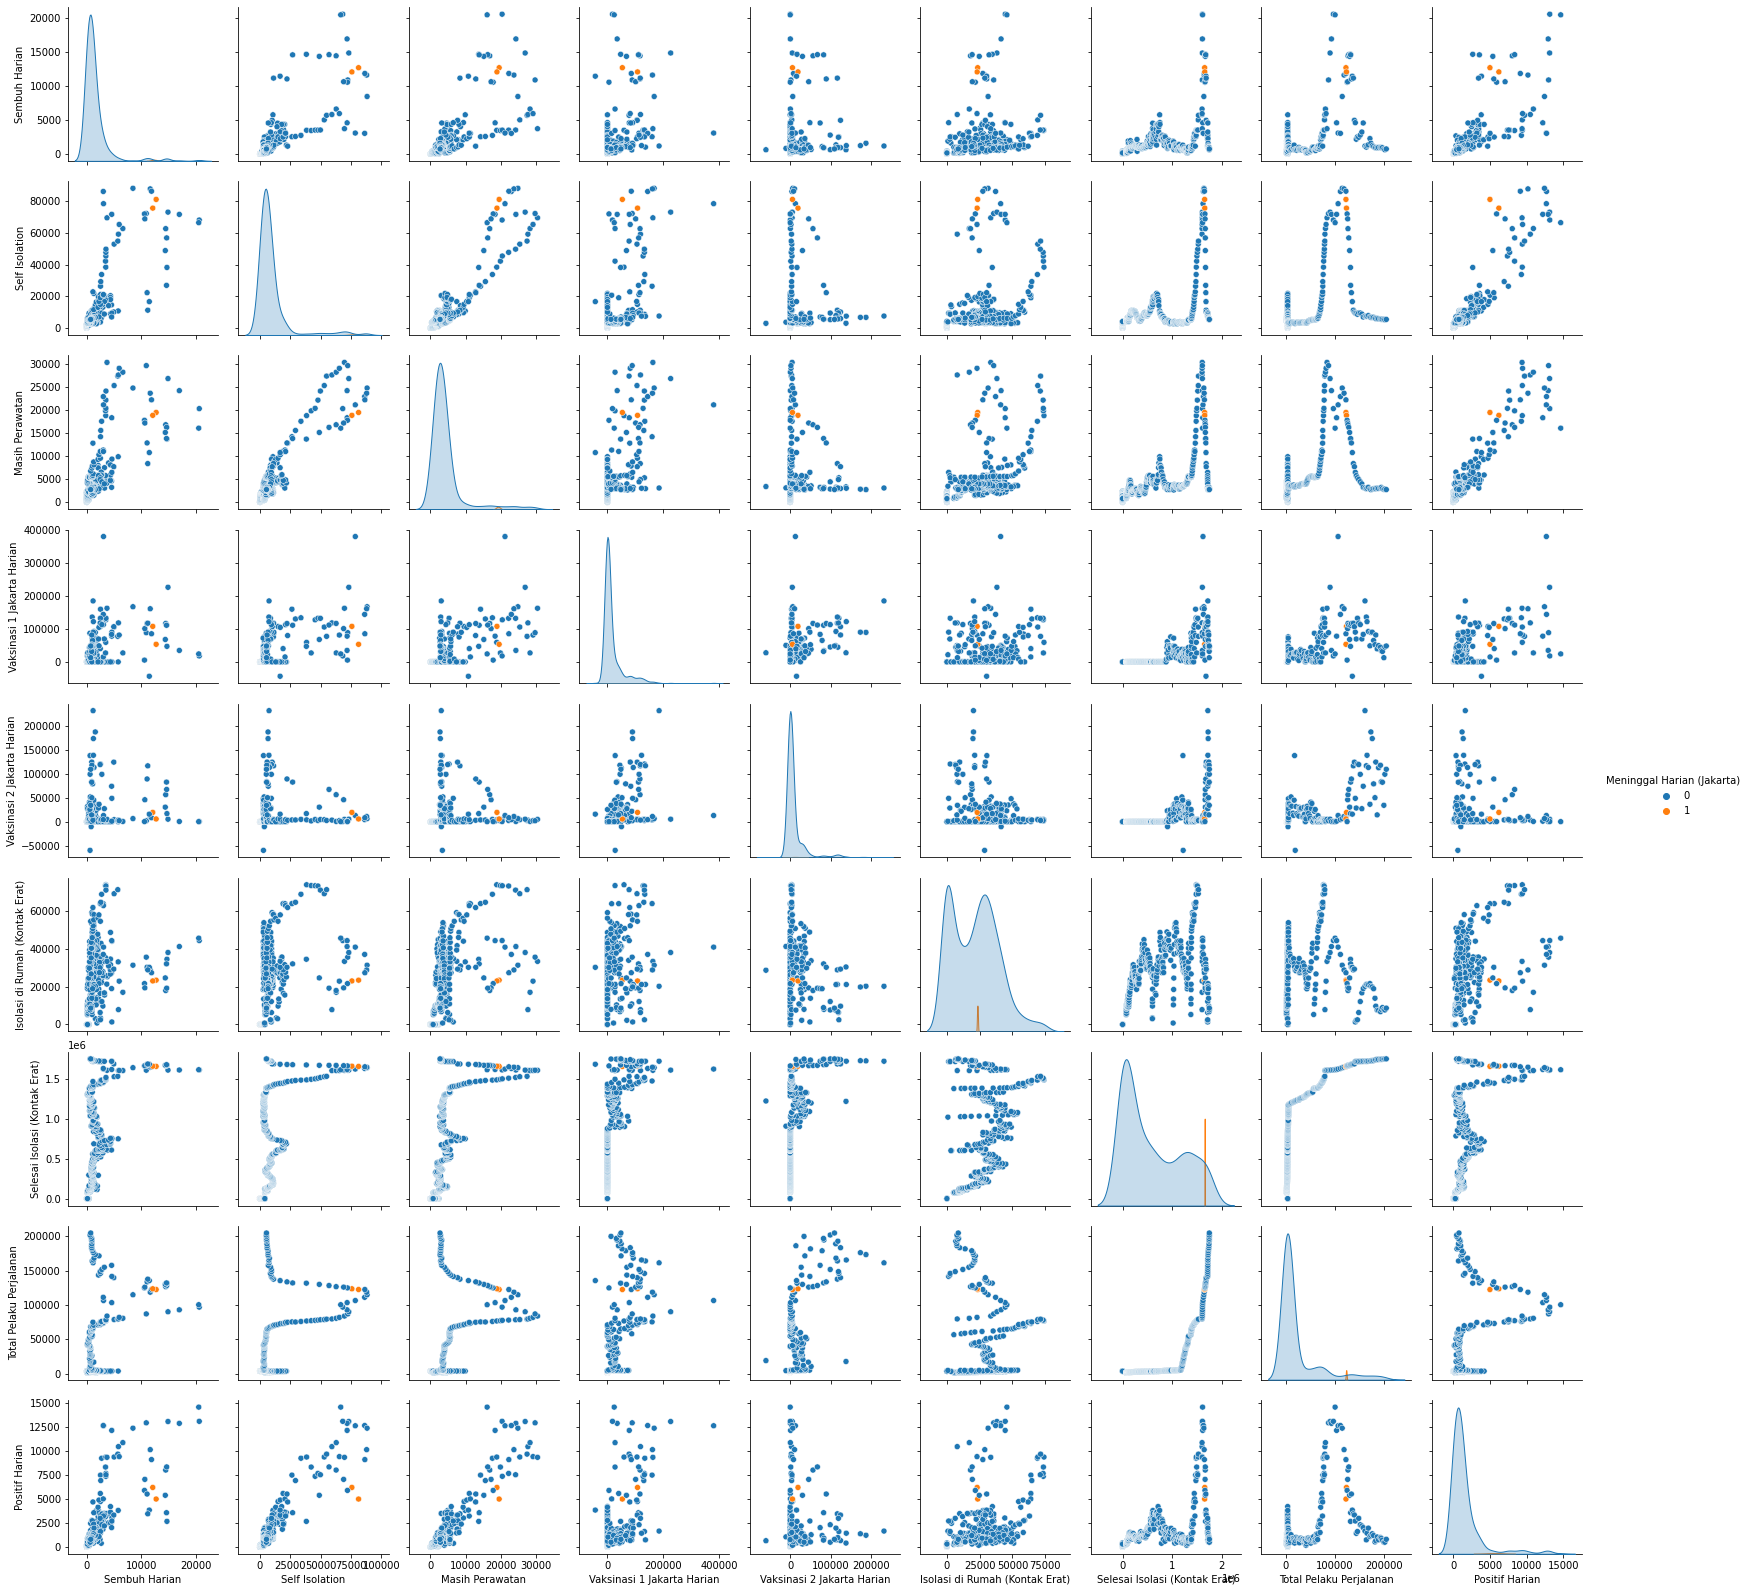

In [ ]:
main_df_new_men = main_df_meninggal[['Sembuh Harian', 'Self Isolation', 'Masih Perawatan', 'Meninggal Harian (Jakarta)', 'Vaksinasi 1 Jakarta Harian', 'Vaksinasi 2 Jakarta Harian', 'Isolasi di Rumah (Kontak Erat)', 'Selesai Isolasi (Kontak Erat)', 'Total Pelaku Perjalanan', 'Positif Harian']]
sns.pairplot(main_df_new_men, hue='Meninggal Harian (Jakarta)')
plt.show()

## Positif 2 Level


In [ ]:
# Untuk yang Positif
from sklearn.model_selection import train_test_split

X = main_df_positif.drop(['Positif Harian'], axis=1)
Y = main_df_positif['Positif Harian']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
print('X_train: ', X_train.shape)
print('Y_train: ', Y_train.shape)
print('X_test: ', X_test.shape)
print('Y_test: ', Y_test.shape)

X_train:  (407, 15)
Y_train:  (407,)
X_test:  (136, 15)
Y_test:  (136,)


In [ ]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[0.17069454, 0.14972578, 0.14389888, ..., 0.4       , 0.49425287,
        0.42857143],
       [0.07647079, 0.0918206 , 0.07632474, ..., 0.36470588, 0.49425287,
        0.48571429],
       [0.09327981, 0.06762895, 0.05157997, ..., 0.48235294, 0.56321839,
        0.37142857],
       ...,
       [0.        , 0.00104303, 0.        , ..., 0.96470588, 0.95402299,
        0.05714286],
       [0.08104266, 0.1661788 , 0.08823529, ..., 0.42352941, 0.50574713,
        0.34285714],
       [0.07609549, 0.15322499, 0.0385999 , ..., 0.44705882, 0.54022989,
        0.4       ]])

In [ ]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(X_train_scaled, Y_train)

pred = LR.predict(X_test_scaled)

In [ ]:
print(LR.coef_)
print(LR.intercept_)

[[ 2.31663979  2.67279422  0.93261138  0.27145083  0.94887948 -0.18680701
   1.56035557  1.40478703  0.78528419 -0.37765853  0.31824721 -0.21213759
  -0.47093071 -0.47047629  0.64164009]]
[-6.03876202]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       124
           1       1.00      0.75      0.86        12

    accuracy                           0.98       136
   macro avg       0.99      0.88      0.92       136
weighted avg       0.98      0.98      0.98       136



In [ ]:
print(confusion_matrix(Y_test, pred))

[[124   0]
 [  3   9]]


## Positif 4 Level

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



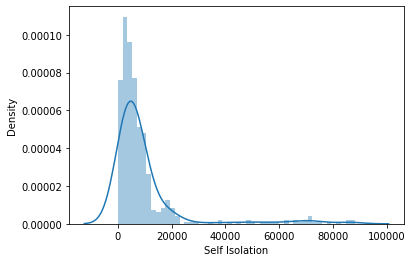

In [ ]:
sns.distplot(main_df['Self Isolation'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



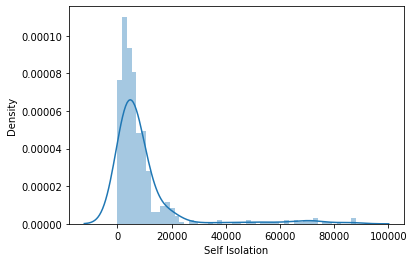

In [ ]:
q = main_df['Self Isolation'].quantile(0.999)
df2 = main_df[main_df['Self Isolation'] < q]
sns.distplot(df2['Self Isolation'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



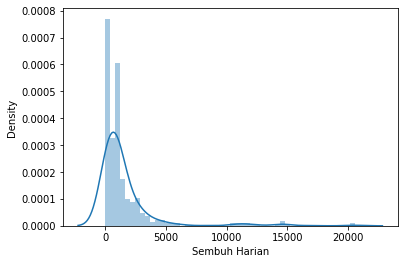

In [ ]:
sns.distplot(main_df['Sembuh Harian'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



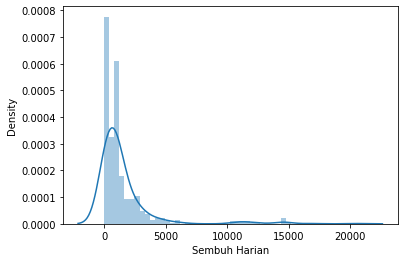

In [ ]:
q = df2['Sembuh Harian'].quantile(0.999)
df3 = df2[df2['Sembuh Harian'] < q]
sns.distplot(df3['Sembuh Harian'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



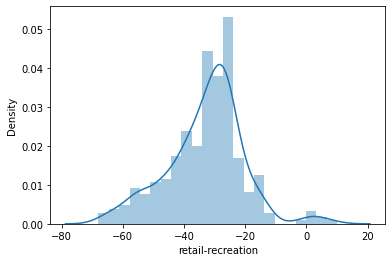

In [ ]:
sns.distplot(main_df['retail-recreation'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



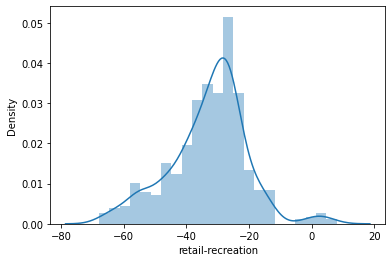

In [ ]:
q = df3['retail-recreation'].quantile(0.999)
df4 = df3[df3['retail-recreation'] < q]
sns.distplot(df4['retail-recreation'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



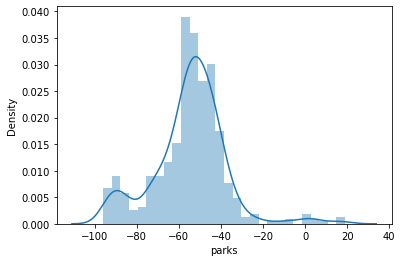

In [ ]:
sns.distplot(main_df['parks'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



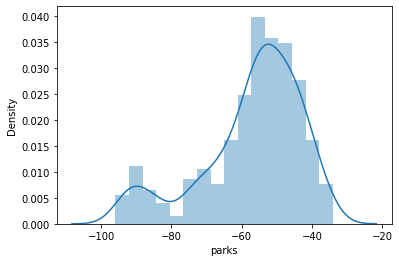

In [ ]:
q = df4['parks'].quantile(0.95)
df5 = df4[df4['parks'] < q]
sns.distplot(df5['parks'])

In [ ]:
df5.shape

(512, 16)

In [ ]:
print(df5['Positif Harian'].min())
print(df5['Positif Harian'].max())

14
14619


In [ ]:
conditions = [
    (df5['Positif Harian'] <= 2200),
    ((df5['Positif Harian'] > 2200) & (df5['Positif Harian'] <= 5500)),
    ((df5['Positif Harian'] > 5500) & (df5['Positif Harian'] <= 11000)),
    (df5['Positif Harian'] > 11000)
    ]

# create a list of the values we want to assign for each condition
values = [1, 2, 3, 4]

# create a new column and use np.select to assign values to it using our lists as arguments
main_df_positif = df5.copy()
main_df_positif['Positif Harian'] = np.select(conditions, values)
main_df_positif

,Self Isolation,Masih Perawatan,Sembuh Harian,Positif Harian,Meninggal Harian (Jakarta),Vaksinasi 1 Jakarta Harian,Vaksinasi 2 Jakarta Harian,Isolasi di Rumah (Kontak Erat),Selesai Isolasi (Kontak Erat),Total Pelaku Perjalanan,retail-recreation,grocery-pharmacy,parks,transit_stations,workplaces,residential
Tanggal,,,,,,,,,,,,,,,,
2020-03-15,0,84,0,1,2,0,0,0,0,4056,-20,3,-37,-19,5,4
2020-03-21,71,157,4,1,3,0,0,0,0,4056,-35,-5,-38,-40,-10,11
2020-03-22,77,177,4,1,6,0,0,0,0,4056,-49,-22,-59,-49,-12,14
2020-03-23,79,225,1,1,0,0,0,0,0,4056,-40,-19,-43,-53,-34,18
2020-03-24,109,260,1,1,5,0,0,0,0,4056,-43,-18,-46,-56,-40,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-08-21,5565,3199,915,1,20,34136,83463,8013,1743757,194384,-31,-1,-52,-43,-19,10
2021-08-22,5584,2947,913,1,21,31902,82364,8939,1744217,196664,-34,-7,-57,-45,-14,9
2021-08-23,5477,2788,731,1,20,12815,34300,8023,1745880,199630,-28,-4,-47,-47,-35,14


In [ ]:
main_df_positif['Positif Harian'].value_counts()

1    420
2     62
3     23
4      7
Name: Positif Harian, dtype: int64

In [ ]:
# Untuk yang Positif
from sklearn.model_selection import train_test_split

X = main_df_positif.drop(['Positif Harian'], axis=1)
Y = main_df_positif['Positif Harian']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
print('X_train: ', X_train.shape)
print('Y_train: ', Y_train.shape)
print('X_test: ', X_test.shape)
print('Y_test: ', Y_test.shape)

X_train:  (384, 15)
Y_train:  (384,)
X_test:  (128, 15)
Y_test:  (128,)


In [ ]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[4.98470357e-02, 3.65596361e-02, 1.57753358e-02, ...,
        5.51724138e-01, 5.71428571e-01, 4.33333333e-01],
       [2.53977641e-01, 4.22001714e-01, 5.38949939e-01, ...,
        3.62068966e-01, 4.16666667e-01, 5.33333333e-01],
       [2.57707923e-02, 6.13832663e-02, 2.93040293e-04, ...,
        2.06896552e-01, 3.92857143e-01, 7.00000000e-01],
       ...,
       [4.59575339e-02, 2.00105492e-02, 9.42612943e-03, ...,
        5.51724138e-01, 5.59523810e-01, 4.33333333e-01],
       [1.57058536e-02, 6.95918771e-02, 9.76800977e-05, ...,
        1.37931034e-01, 3.57142857e-01, 7.33333333e-01],
       [7.50378146e-02, 1.43337509e-01, 4.98168498e-02, ...,
        6.20689655e-01, 5.47619048e-01, 4.00000000e-01]])

In [ ]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(X_train_scaled, Y_train)

pred = LR.predict(X_test_scaled)

In [ ]:
print(LR.coef_)
print(LR.intercept_)

[[-2.96797727 -2.36638564 -2.31985273 -1.96518831 -0.13397139  0.49649472
  -1.1862922  -1.74241241 -0.02043636  0.55303301  1.18681776  0.15992416
   0.51785197  0.25136791  0.41740538]
 [ 0.00909548 -0.44297459  1.18773479  1.2228493  -0.77874381 -0.12468039
  -0.13261522  0.31089931 -0.71611522  0.14982892 -1.4289615   0.30392677
   0.1506824   0.15113763 -1.22867393]
 [ 1.34839084  1.72733561  0.06396005  0.661445    0.17014001 -0.12596152
   0.97906647  0.93526336  0.523107   -0.2384631   0.38400484 -0.39577158
  -0.14284686  0.01056379  0.22580461]
 [ 1.61049096  1.08202462  1.06815789  0.080894    0.74257519 -0.24585281
   0.33984095  0.49624974  0.21344458 -0.46439883 -0.14186109 -0.06807935
  -0.52568751 -0.41306932  0.58546395]]
[ 3.22211287  1.72258747 -2.43495151 -2.50974883]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           1       0.87      1.00      0.93       107
           2       0.50      0.06      0.10        18
           3       0.33      0.50      0.40         2
           4       0.00      0.00      0.00         1

    accuracy                           0.85       128
   macro avg       0.43      0.39      0.36       128
weighted avg       0.80      0.85      0.80       128



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



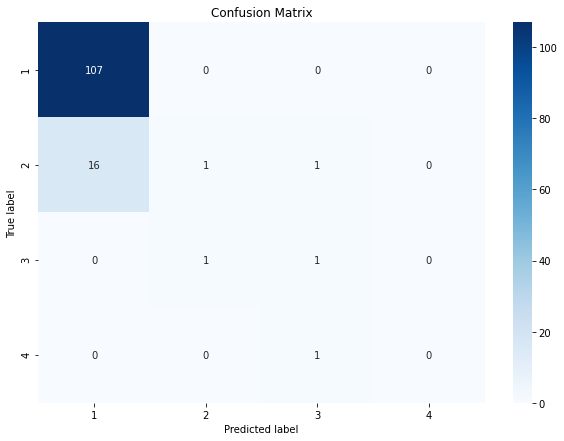

In [ ]:
plt.figure(figsize=(10,7))
ConfMatrix = confusion_matrix(Y_test,pred)
sns.heatmap(ConfMatrix,annot=True, cmap="Blues", fmt="d", 
            xticklabels = ['1', '2', '3', '4'], 
            yticklabels = ['1', '2', '3', '4'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title("Confusion Matrix");

#### Hyperparameter Tuning

In [ ]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

grid = dict(solver=solvers, penalty=penalty, C=c_values)
cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=LR, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train_scaled, Y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 6 members, which is less than n_splits=20.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 6 members, which is less than n_splits=20.

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 6 members, which is less than n_splits=20.



Best: 0.944561 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


In [ ]:
y_pred_new = grid_result.predict(X_test_scaled)
print(classification_report(Y_test, y_pred_new))

              precision    recall  f1-score   support

           1       0.96      0.99      0.98       107
           2       0.93      0.72      0.81        18
           3       0.50      1.00      0.67         2
           4       0.00      0.00      0.00         1

    accuracy                           0.95       128
   macro avg       0.60      0.68      0.61       128
weighted avg       0.94      0.95      0.94       128



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
print(confusion_matrix(Y_test, y_pred_new))

[[106   1   0   0]
 [  4  13   1   0]
 [  0   0   2   0]
 [  0   0   1   0]]


## Meninggal

In [ ]:
# Untuk yang Meninggal
from sklearn.model_selection import train_test_split

X = main_df_meninggal.drop(['Meninggal Harian (Jakarta)'], axis=1)
Y = main_df_meninggal['Meninggal Harian (Jakarta)']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)
print('X_train: ', X_train.shape)
print('Y_train: ', Y_train.shape)
print('X_test: ', X_test.shape)
print('Y_test: ', Y_test.shape)

X_train:  (407, 15)
Y_train:  (407,)
X_test:  (136, 15)
Y_test:  (136,)


In [ ]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled

array([[0.17069454, 0.14972578, 0.14389888, ..., 0.4       , 0.49425287,
        0.42857143],
       [0.07647079, 0.0918206 , 0.07632474, ..., 0.36470588, 0.49425287,
        0.48571429],
       [0.09327981, 0.06762895, 0.05157997, ..., 0.48235294, 0.56321839,
        0.37142857],
       ...,
       [0.        , 0.00104303, 0.        , ..., 0.96470588, 0.95402299,
        0.05714286],
       [0.08104266, 0.1661788 , 0.08823529, ..., 0.42352941, 0.50574713,
        0.34285714],
       [0.07609549, 0.15322499, 0.0385999 , ..., 0.44705882, 0.54022989,
        0.4       ]])

In [ ]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()
LR.fit(X_train_scaled, Y_train)

pred = LR.predict(X_test_scaled)

In [ ]:
print(LR.coef_)
print(LR.intercept_)

[[ 1.13798866  0.60768163  0.74374271  0.24256539  0.13421676 -0.04853359
  -0.07374808  0.68517499  0.59953    -0.26059353 -0.13492748 -0.04953676
  -0.35776882 -0.60942324  0.45453367]]
[-5.75079068]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       136

    accuracy                           1.00       136
   macro avg       1.00      1.00      1.00       136
weighted avg       1.00      1.00      1.00       136



In [ ]:
print(confusion_matrix(Y_test, pred))

[[136]]


# Modeling

## Linear Regression

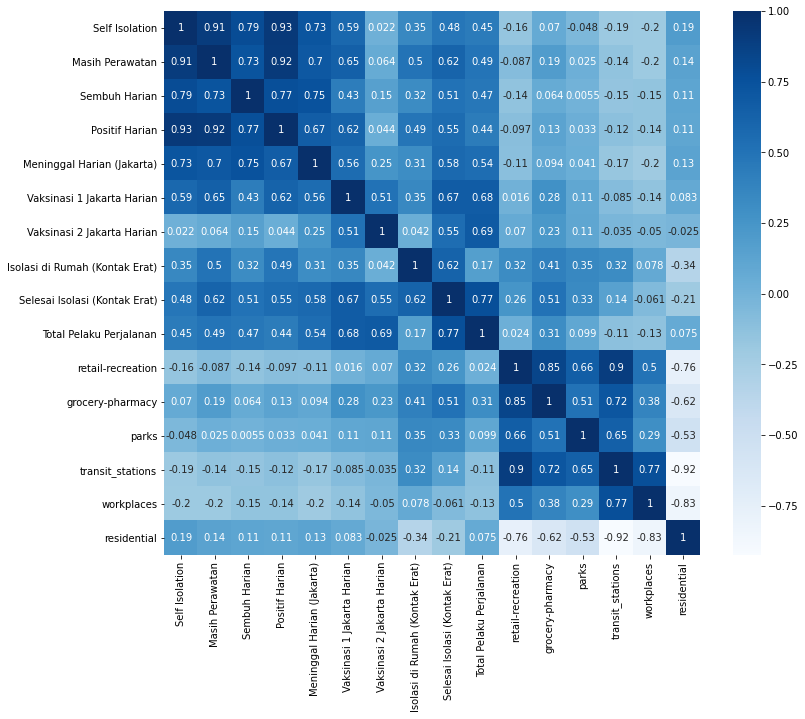

In [ ]:
#Feature Selection
plt.figure(figsize=(12,10))
corr = main_df.corr()
sns.heatmap(corr, cmap = 'Blues', annot=True)
plt.show()

In [ ]:
#Correlation with output variable
cor_target = abs(corr["Positif Harian"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.3]
relevant_features

Self Isolation                    0.925949
Masih Perawatan                   0.924378
Sembuh Harian                     0.771383
Positif Harian                    1.000000
Meninggal Harian (Jakarta)        0.665239
Vaksinasi 1 Jakarta Harian        0.619575
Isolasi di Rumah (Kontak Erat)    0.489231
Selesai Isolasi (Kontak Erat)     0.554117
Total Pelaku Perjalanan           0.443782
Name: Positif Harian, dtype: float64

**Markicob bikin model regresi thd positif harian dengan input variabel seluruh variabel lainnya lol**

In [ ]:
from sklearn.model_selection import train_test_split

X = main_df.drop(['Positif Harian'], axis=1)
Y = main_df['Positif Harian']

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.25, random_state=0)
print("X＿train : ", X_train.shape)
print("y_train : ", y_train.shape)
print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

X＿train :  (407, 15)
y_train :  (407,)
X_test :  (136, 15)
y_test :  (136,)


**Markicob kita normalisasi datanya**

In [ ]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled

array([[0.17069454, 0.14972578, 0.14389888, ..., 0.4       , 0.49425287,
        0.42857143],
       [0.07647079, 0.0918206 , 0.07632474, ..., 0.36470588, 0.49425287,
        0.48571429],
       [0.09327981, 0.06762895, 0.05157997, ..., 0.48235294, 0.56321839,
        0.37142857],
       ...,
       [0.        , 0.00104303, 0.        , ..., 0.96470588, 0.95402299,
        0.05714286],
       [0.08104266, 0.1661788 , 0.08823529, ..., 0.42352941, 0.50574713,
        0.34285714],
       [0.07609549, 0.15322499, 0.0385999 , ..., 0.44705882, 0.54022989,
        0.4       ]])

**Markicob buat model linear regressionnya**

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

**Markicob Evaluasi dengan R2**

In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
from sklearn import metrics

r2_square = metrics.r2_score(y_test, y_pred)
print("R2 Score: ", r2_square)

R2 Score:  0.9031191029582181


**Markicob Evaluasi dengan MSE dan RMSE**

In [ ]:
from sklearn.metrics import mean_squared_error
import math
MSE = np.square(np.subtract(y_test,y_pred)).mean()
RMSE = math.sqrt(MSE)
print('MSE = ', MSE)
print('RMSE = ', RMSE)

MSE =  881911.4201640489
RMSE =  939.101389714683
